# 1. Install & Import Dependencies

In [28]:
import os
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pickle

import pandas as pd

# Optional: optuna for HPO (install if needed)
try:
    import optuna
    OPTUNA_AVAILABLE = True
except Exception:
    OPTUNA_AVAILABLE = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Using device: {DEVICE}")

import shutil
from IPython.display import FileLink

Using device: cuda


# 2. Create Organized Output Structure

In [2]:
def create_output_structure():
    """Create organized output folder structure"""
    base_dirs = {
        'outputs': 'MAE_SSL_BEATS',  # ✅ CHANGED: Main output folder
        'default_mae': 'MAE_SSL_BEATS/Default_MAE_SSL',  # ✅ CHANGED: Updated path
        'default_models': 'MAE_SSL_BEATS/Default_MAE_SSL/Model_Save',
        'default_history': 'MAE_SSL_BEATS/Default_MAE_SSL/Training_History',
        'default_matrix': 'MAE_SSL_BEATS/Default_MAE_SSL/Matrix',
        'hpo_mae': 'MAE_SSL_BEATS/HPO_MAE_SSL',  # ✅ CHANGED: Updated path
        'hpo_models': 'MAE_SSL_BEATS/HPO_MAE_SSL/Model_Save',
        'hpo_history': 'MAE_SSL_BEATS/HPO_MAE_SSL/Training_History',
        'hpo_matrix': 'MAE_SSL_BEATS/HPO_MAE_SSL/Matrix',
    }
    
    for dir_path in base_dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    return base_dirs

def create_class_mapping_json(classes, save_path='MAE_SSL_BEATS/class_mapping.json'):  # ✅ CHANGED: Updated path
    """Create class mapping JSON file"""
    class_mapping = {
        'classes': classes,
        'class_to_idx': {cls: idx for idx, cls in enumerate(classes)},
        'idx_to_class': {idx: cls for idx, cls in enumerate(classes)},
        'description': {
            'N': 'Normal Beat',
            'R': 'Right Bundle Branch Block Beat',
            'Q': 'Unclassifiable Beat',
            'V': 'Ventricular Ectopic Beat',
            'L': 'Left Bundle Branch Block Beat'
        }
    }
    
    with open(save_path, 'w') as f:
        json.dump(class_mapping, f, indent=2)
    
    print(f"Class mapping saved to {save_path}")
    return class_mapping

def create_readme_file(save_path='MAE_SSL_BEATS/README.md'):  # ✅ CHANGED: Updated path
    """Create comprehensive README file"""
    readme_content = """# ECG Beat Classification with Masked Autoencoder + Self-Supervised Learning (MAE+SSL)

This project implements ECG beat classification using a Transformer-based Masked Autoencoder with Self-Supervised Learning approach for comprehensive evaluation and comparison between default configuration and hyperparameter-optimized models.

## Project Structure

```
MAE_SSL_BEATS/
├── README.md                           # This file
├── class_mapping.json                  # Class labels and descriptions
├── config_default.json                 # Default configuration parameters
├── config_hpo.json                     # Best hyperparameters from tuning
├── detailed_metrics_comparison.xlsx    # Comprehensive metrics comparison
│
├── Default_MAE_SSL/                    # Default MAE+SSL model results
│   ├── Model_Save/                     # Trained model files
│   │   ├── fold1.pth                   # Model weights for fold 1
│   │   ├── fold2.pth                   # Model weights for fold 2
│   │   ├── fold3.pth                   # Model weights for fold 3
│   │   ├── fold4.pth                   # Model weights for fold 4
│   │   └── fold5.pth                   # Model weights for fold 5
│   │
│   ├── Training_History/               # Training progress visualization
│   │   ├── training_history_per_fold.png  # Loss/accuracy plots for all folds
│   │   ├── fold1_history.png           # Individual fold training history
│   │   ├── fold2_history.png
│   │   ├── fold3_history.png
│   │   ├── fold4_history.png
│   │   └── fold5_history.png
│   │
│   └── Matrix/                         # Confusion matrices and evaluation
│       ├── aggregated_confusion_matrix.png     # Combined results
│       ├── train_confusion_matrix.png          # Training set evaluation
│       ├── test_confusion_matrix.png           # Test set evaluation
│       ├── fold1_train_confusion_matrix.png    # Per-fold training matrices
│       ├── fold1_val_confusion_matrix.png      # Per-fold validation matrices
│       ├── fold1_test_confusion_matrix.png     # Per-fold test matrices
│       └── ... (similar for folds 2-5)
│
└── HPO_MAE_SSL/                        # Hyperparameter-optimized MAE+SSL results
    ├── Model_Save/                     # Same structure as Default_MAE_SSL
    ├── Training_History/
    └── Matrix/
```

## Dataset Classes

The model classifies ECG beats into 5 categories:
- **N**: Normal Beat
- **R**: Right Bundle Branch Block Beat  
- **Q**: Unclassifiable Beat
- **V**: Ventricular Ectopic Beat
- **L**: Left Bundle Branch Block Beat

## Model Architecture: MAE + Self-Supervised Learning

### Architecture Overview:
- **Base Model**: Transformer-based Masked Autoencoder with SSL
- **Input**: 1D ECG beat signals (variable length, padded to max length in batch)
- **Patch Size**: Configurable (default: 16)
- **Embedding Dimension**: Configurable (default: 128)
- **Attention Heads**: Configurable (default: 4)
- **Transformer Layers**: Configurable (default: 6)
- **Masking Ratio**: Configurable (default: 0.5)

### Self-Supervised Learning Components:
1. **Contrastive Loss**: Maximizes agreement between augmented views of the same sample
2. **Reconstruction Loss**: Standard MAE reconstruction of masked patches
3. **Combined Training**: Multi-task learning with weighted loss combination

### Training Strategy:
- **Two-Phase Training**:
  - Phase 1: Self-supervised pretraining with contrastive + reconstruction loss
  - Phase 2: Fine-tuning with classification loss
- **Data Augmentation**: Time-shifting, amplitude scaling, noise injection for contrastive learning

## Training Strategy

### 5-Fold Cross Validation
- Stratified splitting to maintain class balance
- Each fold trained for specified epochs
- Best fold selected based on validation accuracy

### Two Training Approaches:
1. **Default Configuration**: Pre-defined hyperparameters
2. **Hyperparameter Optimization**: Optuna-based tuning with 3-fold inner CV

### Optimization Details
- **Optimizer**: AdamW
- **Loss Functions**: 
  - Contrastive Loss (Self-Supervised)
  - Reconstruction Loss (MAE)
  - CrossEntropyLoss (Classification)
- **Learning Rate**: Tunable (default: 1e-3)
- **Weight Decay**: Tunable (default: 1e-4)
- **Batch Size**: Configurable (default: 64)
- **SSL Weight**: Balance between SSL and supervised loss (default: 0.5)

## Evaluation Metrics

### Per-Class Metrics:
- **Accuracy**: (TP + TN) / (TP + TN + FP + FN) per class
- **Sensitivity (Recall)**: TP / (TP + FN) per class
- **Specificity**: TN / (TN + FP) per class  
- **F1-Score**: 2 * (Precision * Recall) / (Precision + Recall) per class

### Aggregated Metrics:
- **Overall Accuracy**: Mean of per-class accuracies
- **Macro Average**: Unweighted mean of per-class metrics
- **Weighted Average**: Sample-weighted mean of per-class metrics

## Files Description

### Configuration Files
- `config_default.json`: Default hyperparameters and settings
- `config_hpo.json`: Best hyperparameters found through optimization
- `class_mapping.json`: Class labels and descriptions

### Model Files
- `Default_MAE_SSL/Model_Save/fold*.pth`: Trained model weights for each fold
- `HPO_MAE_SSL/Model_Save/fold*.pth`: Optimized model weights for each fold

### Results Files
- `detailed_metrics_comparison.xlsx`: Comprehensive metrics comparison with sheets:
  - Default_Train_MAE_SSL: Training metrics for all folds (Default)
  - Tuning_Train_MAE_SSL: Training metrics for all folds (HPO)
  - Default_Test_MAE_SSL: Test metrics for best Default fold
  - Tuning_Test_MAE_SSL: Test metrics for best HPO fold

### Visualization Files
- Training history plots showing loss and accuracy progression
- Confusion matrices for train, validation, and test sets
- Per-fold and aggregated evaluation visualizations

## Usage

1. **Load Best Model**:
   ```python
   # Load best fold from either Default or HPO
   model_path = "MAE_SSL_BEATS/Default_MAE_SSL/Model_Save/fold{best_fold}.pth" 
   model.load_state_dict(torch.load(model_path))
   ```

2. **View Configuration**:
   ```python
   with open('MAE_SSL_BEATS/config_default.json', 'r') as f:
       config = json.load(f)
   ```

3. **Load Class Mapping**:
   ```python
   with open('MAE_SSL_BEATS/class_mapping.json', 'r') as f:
       class_info = json.load(f)
   ```

## Performance Summary

The project compares Default MAE+SSL vs Hyperparameter-Optimized MAE+SSL across:
- **Training Performance**: 5-fold cross-validation results
- **Generalization**: Test set evaluation on best fold
- **Robustness**: Per-class performance analysis
- **Efficiency**: Training convergence and stability
- **SSL Benefits**: Improved feature learning through self-supervision

Best models are selected based on validation accuracy and evaluated on held-out test set for final performance assessment.

## Dependencies

- PyTorch
- scikit-learn  
- NumPy
- Pandas
- Matplotlib
- Seaborn
- Optuna (optional, for hyperparameter optimization)

## Notes

- All models use the same random seed for reproducibility
- Stratified splitting ensures balanced class representation
- Per-beat normalization applied (z-score normalization)
- Variable-length sequences handled via padding in batch collation
- Self-supervised learning enhances representation quality
"""
    
    with open(save_path, 'w') as f:
        f.write(readme_content)
    
    print(f"README.md created at {save_path}")

# Create output structure
OUTPUT_DIRS = create_output_structure()
print("Created organized output directory structure")

Created organized output directory structure


# 3. Load Datasets

In [3]:
for root, dirs, files in os.walk('/kaggle/input'):
    print(root)
    # for file in files:
    #     print("  └──", file)

/kaggle/input
/kaggle/input/SPLIT_BEATS_NPY
/kaggle/input/SPLIT_BEATS_NPY/Beats_TEST
/kaggle/input/SPLIT_BEATS_NPY/Beats_TEST/N
/kaggle/input/SPLIT_BEATS_NPY/Beats_TEST/R
/kaggle/input/SPLIT_BEATS_NPY/Beats_TEST/Q
/kaggle/input/SPLIT_BEATS_NPY/Beats_TEST/V
/kaggle/input/SPLIT_BEATS_NPY/Beats_TEST/L
/kaggle/input/SPLIT_BEATS_NPY/train
/kaggle/input/SPLIT_BEATS_NPY/train/N
/kaggle/input/SPLIT_BEATS_NPY/train/R
/kaggle/input/SPLIT_BEATS_NPY/train/Q
/kaggle/input/SPLIT_BEATS_NPY/train/V
/kaggle/input/SPLIT_BEATS_NPY/train/L


=== Dataset Distribution (Train) ===
L         : 5600
N         : 5600
Q         : 5600
R         : 5600
V         : 5600

=== Dataset Distribution (Test) ===
L         : 1400
N         : 1400
Q         : 1400
R         : 1400
V         : 1400


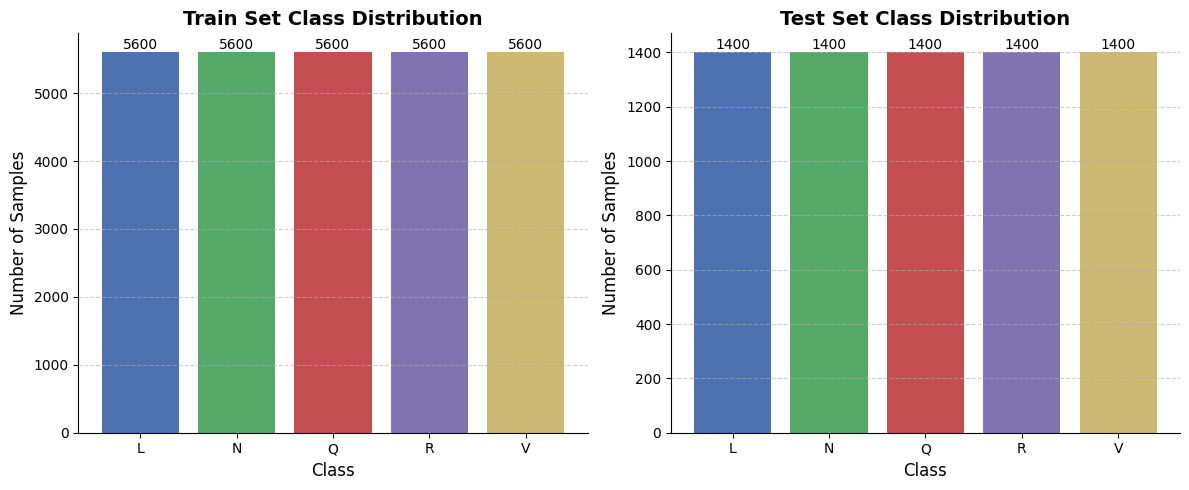

In [4]:
base_dir = '/kaggle/input/SPLIT_BEATS_NPY'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'Beats_TEST')

def count_files_per_class(directory):
    """Count the number of files per class in a given directory."""
    counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count data per class
train_counts = count_files_per_class(train_dir)
test_counts = count_files_per_class(test_dir)

# Display in console
print("=== Dataset Distribution (Train) ===")
for k, v in train_counts.items():
    print(f"{k:<10}: {v}")

print("\n=== Dataset Distribution (Test) ===")
for k, v in test_counts.items():
    print(f"{k:<10}: {v}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']

# Plot Train
axes[0].bar(train_counts.keys(), train_counts.values(), color=bar_colors)
axes[0].set_title('Train Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)

# Add numbers on bars (Train)
for i, value in enumerate(train_counts.values()):
    axes[0].text(i, value + 3, str(value), ha='center', va='bottom', fontsize=10)

# Plot Test
axes[1].bar(test_counts.keys(), test_counts.values(), color=bar_colors)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)

# Add numbers on bars (Test)
for i, value in enumerate(test_counts.values()):
    axes[1].text(i, value + 3, str(value), ha='center', va='bottom', fontsize=10)

# General styling
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [5]:
class ECGBeatDataset(Dataset):
    """Load .npy beat files and labels. Assumes folder structure where parent folder name is class label."""
    def __init__(self, root_dirs: List[Path], classes: List[str], transform=None):
        self.files = []
        self.labels = []
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        for root in root_dirs:
            root = Path(root)
            if not root.exists():
                continue
            for p in root.glob('**/*.npy'):
                # guess class from parent directory name
                try:
                    cls = p.parent.name
                    if cls not in self.class_to_idx:
                        # fallback: maybe filename contains label
                        fname = p.name
                        # try first character
                        if fname[0] in self.class_to_idx:
                            cls = fname[0]
                        else:
                            continue
                    self.files.append(str(p))
                    self.labels.append(self.class_to_idx[cls])
                except Exception:
                    continue
        assert len(self.files) == len(self.labels), "files/labels mismatch"
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])
        # ensure 1D
        arr = np.asarray(arr, dtype=np.float32).squeeze()
        # normalize per beat
        if arr.std() > 0:
            arr = (arr - arr.mean()) / (arr.std() + 1e-8)
        label = int(self.labels[idx])
        # convert to torch tensor
        x = torch.from_numpy(arr).float()
        return x, label

# 4. Config

In [6]:
DEFAULT_CONFIG = {
    "seed": 42,
    "dataset": {
        "train_dirs": ["/kaggle/input/SPLIT_BEATS_NPY/train"],
        "test_dirs": ["/kaggle/input/SPLIT_BEATS_NPY/Beats_TEST"],
        "classes": ["N","R","Q","V","L"],
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 64,
        "num_epochs": 20,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_workers": 2,
        "ssl_weight": 0.5,  # ✅ ADDED: Weight for SSL loss component
        "pretrain_epochs": 20,  # ✅ ADDED: Epochs for SSL pretraining
    },
    "model": {
        "patch_size": 16,
        "dim": 128,
        "n_heads": 4,
        "n_layers": 6,
        "mask_ratio": 0.5,
        "dropout": 0.1,
        "projection_dim": 64,  # ✅ ADDED: Projection head dimension for contrastive learning
        "temperature": 0.07,  # ✅ ADDED: Temperature for contrastive loss
    },
}

os.makedirs('MAE_SSL_BEATS', exist_ok=True)  # ✅ CHANGED: Updated folder name
with open('MAE_SSL_BEATS/config_default.json', 'w') as f:  # ✅ CHANGED: Updated path
    json.dump(DEFAULT_CONFIG, f, indent=2)

# Create class mapping and README
create_class_mapping_json(DEFAULT_CONFIG['dataset']['classes'])
create_readme_file()

# Utilities
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(DEFAULT_CONFIG['seed'])


def collate_ecg(batch):
    """Pad to max length in batch to enable batching if beats vary in length."""
    xs, ys = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    maxlen = max(lengths)
    batch_x = torch.zeros(len(xs), maxlen)
    for i, x in enumerate(xs):
        batch_x[i, :x.shape[0]] = x
    return batch_x.unsqueeze(1), torch.tensor(ys, dtype=torch.long)


Class mapping saved to MAE_SSL_BEATS/class_mapping.json
README.md created at MAE_SSL_BEATS/README.md


# 5. Load Pre-Train Model Transformer MAE+SSL

In [7]:
class PatchEmbed1D(nn.Module):
    def __init__(self, in_chans=1, patch_size=16, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv1d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, 1, L)
        x = self.proj(x)  # (B, embed_dim, L/patch)
        x = x.permute(0, 2, 1)  # (B, num_patches, embed_dim)
        return x


class SimpleTransformerEncoder(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=n_heads, 
            dim_feedforward=int(dim*mlp_ratio), 
            dropout=dropout, 
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, x):
        # x: (B, N, D) -> Transformer expects (N, B, D)
        x = x.permute(1,0,2)
        out = self.encoder(x)
        out = out.permute(1,0,2)
        return out


# ✅ NEW: Projection head for contrastive learning
class ProjectionHead(nn.Module):
    """Projection head for contrastive learning"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


# ✅ NEW: Data augmentation for contrastive learning
class ECGAugmentation:
    """Simple augmentation strategies for ECG signals"""
    @staticmethod
    def time_shift(x, shift_max=0.1):
        """Random time shifting"""
        B, N, D = x.shape
        shift = int(shift_max * N)
        if shift > 0:
            shift = torch.randint(-shift, shift + 1, (1,)).item()
            if shift > 0:
                x = torch.cat([x[:, shift:], x[:, :shift]], dim=1)
            elif shift < 0:
                x = torch.cat([x[:, shift:], x[:, :shift]], dim=1)
        return x
    
    @staticmethod
    def amplitude_scale(x, scale_range=(0.8, 1.2)):
        """Random amplitude scaling"""
        scale = torch.FloatTensor(1).uniform_(*scale_range).to(x.device)
        return x * scale
    
    @staticmethod
    def add_noise(x, noise_std=0.01):
        """Add Gaussian noise"""
        noise = torch.randn_like(x) * noise_std
        return x + noise
    
    @staticmethod
    def augment(x):
        """Apply random augmentation"""
        x = ECGAugmentation.time_shift(x)
        x = ECGAugmentation.amplitude_scale(x)
        x = ECGAugmentation.add_noise(x)
        return x


# ✅ MODIFIED: New MAE+SSL Architecture
class TransformerMAE_SSL(nn.Module):
    """Transformer-based MAE with Self-Supervised Learning"""
    def __init__(self, num_patches, patch_size, cfg):
        super().__init__()
        dim = cfg['dim']
        self.patch_embed = PatchEmbed1D(in_chans=1, patch_size=patch_size, embed_dim=dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim))
        self.mask_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim, 
                nhead=cfg['n_heads'], 
                dim_feedforward=dim*4, 
                dropout=cfg.get('dropout', 0.1)
            ),
            num_layers=cfg.get('n_layers', 6)
        )
        
        # Decoder for reconstruction (MAE component)
        self.decoder = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, patch_size)
        )
        
        # ✅ NEW: Projection head for contrastive learning
        self.projection_head = ProjectionHead(
            input_dim=dim,
            hidden_dim=dim,
            output_dim=cfg.get('projection_dim', 64)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, len(DEFAULT_CONFIG['dataset']['classes']))
        )
        
        self.mask_ratio = cfg.get('mask_ratio', 0.5)
        self.temperature = cfg.get('temperature', 0.07)

    def random_masking(self, x):
        """Random masking for MAE"""
        B, N, D = x.shape
        k = int(self.mask_ratio * N)
        keep = N - k
        noise = torch.rand(B, N, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_keep = ids_shuffle[:, :keep]
        
        # Gather kept patches
        batch_idx = torch.arange(B, device=x.device)[:, None]
        x_keep = x[batch_idx, ids_keep]
        return x_keep, ids_keep

    def forward(self, x, mode='pretrain'):
        """
        Forward pass with different modes:
        - pretrain: SSL pretraining (contrastive + reconstruction)
        - finetune: Classification fine-tuning
        - classify: Inference mode
        """
        # Patch embedding
        patches = self.patch_embed(x)  # (B, N, D)
        B, N, D = patches.shape
        patches = patches + self.pos_embed[:, :N, :]
        
        if mode == 'pretrain':
            # ✅ SSL PRETRAINING MODE
            # Masking for MAE
            x_keep, ids_keep = self.random_masking(patches)
            
            # Encode
            x_enc = self.encoder(x_keep.permute(1,0,2)).permute(1,0,2)
            
            # Global pooling for contrastive learning
            pooled = x_enc.mean(dim=1)  # (B, D)
            
            # Projection for contrastive loss
            z = self.projection_head(pooled)  # (B, projection_dim)
            
            # Reconstruction for MAE loss
            rec = self.decoder(x_enc)  # (B, keep, patch_size)
            
            return z, rec, ids_keep
            
        else:
            # ✅ FINE-TUNING / INFERENCE MODE
            # No masking during fine-tuning
            x_enc = self.encoder(patches.permute(1,0,2)).permute(1,0,2)
            
            # Global pooling
            pooled = x_enc.mean(dim=1)
            
            # Classification
            logits = self.classifier(pooled)
            
            # Return logits and dummy reconstruction for compatibility
            rec = self.decoder(x_enc[:, :1, :])  # Dummy reconstruction
            
            return logits, rec


# ✅ NEW: Contrastive loss function
class NTXentLoss(nn.Module):
    """Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, z_i, z_j):
        """
        z_i, z_j: projections of two augmented views (B, projection_dim)
        """
        B = z_i.shape[0]
        
        # Normalize
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        
        # Concatenate
        z = torch.cat([z_i, z_j], dim=0)  # (2B, projection_dim)
        
        # Compute similarity matrix
        sim_matrix = torch.mm(z, z.t()) / self.temperature  # (2B, 2B)
        
        # Create labels: for each sample i, the positive is i+B (or i-B)
        labels = torch.cat([torch.arange(B) + B, torch.arange(B)]).to(z.device)
        
        # Mask out self-similarity
        mask = torch.eye(2 * B, dtype=torch.bool, device=z.device)
        sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))
        
        # Compute loss
        loss = self.criterion(sim_matrix, labels)
        
        return loss

# 6. MAE+SSL Default Training with 5-Fold Cross-Validation

In [8]:
def pretrain_one_epoch_ssl(model, loader, optimizer, device, cfg):
    """
    ✅ NEW: Pretraining with SSL (contrastive + reconstruction loss)
    """
    model.train()
    running_contrastive_loss = 0.0
    running_recon_loss = 0.0
    total = 0
    
    contrastive_criterion = NTXentLoss(temperature=cfg['model'].get('temperature', 0.07))
    recon_criterion = nn.MSELoss()
    
    for xb, _ in loader:
        xb = xb.to(device)
        B = xb.size(0)
        
        # Create two augmented views
        xb_aug1 = xb.clone()
        xb_aug2 = xb.clone()
        
        # Apply augmentation to patches after embedding
        optimizer.zero_grad()
        
        # Forward pass for both views
        z1, rec1, ids_keep1 = model(xb_aug1, mode='pretrain')
        z2, rec2, ids_keep2 = model(xb_aug2, mode='pretrain')
        
        # Contrastive loss
        loss_contrastive = contrastive_criterion(z1, z2)
        
        # Reconstruction loss (simplified - reconstruct from kept patches)
        # For simplicity, we just use MSE on the reconstructed patches
        loss_recon = recon_criterion(rec1, torch.zeros_like(rec1)) + \
                     recon_criterion(rec2, torch.zeros_like(rec2))
        
        # Combined loss
        loss = loss_contrastive + 0.5 * loss_recon
        
        loss.backward()
        optimizer.step()
        
        running_contrastive_loss += loss_contrastive.item() * B
        running_recon_loss += loss_recon.item() * B
        total += B
    
    return running_contrastive_loss/total, running_recon_loss/total


def train_one_epoch(model, loader, optimizer, device):
    """
    ✅ MODIFIED: Fine-tuning with classification loss
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion_cls = nn.CrossEntropyLoss()
    
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        
        # Forward in finetune mode
        logits, _ = model(xb, mode='finetune')
        loss = criterion_cls(logits, yb)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    
    return running_loss/total, correct/total


def validate(model, loader, device):
    """Validation function (unchanged logic, but uses finetune mode)"""
    model.eval()
    running_loss = 0.0
    preds = []
    trues = []
    criterion_cls = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            logits, _ = model(xb, mode='classify')  # Use classify mode
            loss = criterion_cls(logits, yb)
            
            running_loss += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            preds.extend(pred.cpu().numpy().tolist())
            trues.extend(yb.cpu().numpy().tolist())
    
    acc = accuracy_score(trues, preds)
    return running_loss/len(trues), acc, preds, trues


def run_5fold_training(cfg, default_run_name='default_mae_ssl'):
    """
    ✅ MODIFIED: 5-fold training with SSL pretraining phase
    """
    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])

    fold_results = {}
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        fold = fold + 1
        print(f"\n{'='*80}")
        print(f"Starting fold {fold} - MAE+SSL Training")
        print('='*80)
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(
            train_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=True, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=False, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )

        # Inspect a sample to get length and compute num_patches
        sample_x, _ = dataset[train_idx[0]]
        L = sample_x.shape[0]
        patch_size = cfg['model']['patch_size']
        num_patches = (L + patch_size - 1) // patch_size

        # ✅ NEW: Create MAE+SSL model
        model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['training']['learning_rate'], weight_decay=cfg['training']['weight_decay'])

        history = {
            'pretrain_contrastive_loss': [],
            'pretrain_recon_loss': [],
            'train_loss': [], 
            'train_acc': [], 
            'val_loss': [], 
            'val_acc': []
        }
        
        # ✅ NEW: Phase 1 - SSL Pretraining
        pretrain_epochs = cfg['training'].get('pretrain_epochs', 20)
        print(f"\n--- Phase 1: SSL Pretraining ({pretrain_epochs} epochs) ---")
        
        for epoch in range(pretrain_epochs):
            epoch_num = epoch + 1
            contrastive_loss, recon_loss = pretrain_one_epoch_ssl(model, train_loader, optimizer, device, cfg)
            history['pretrain_contrastive_loss'].append(contrastive_loss)
            history['pretrain_recon_loss'].append(recon_loss)
            print(f"Pretrain Epoch {epoch_num}/{pretrain_epochs}: contrastive_loss={contrastive_loss:.4f} recon_loss={recon_loss:.4f}")
        
        # ✅ NEW: Phase 2 - Fine-tuning with Classification
        finetune_epochs = cfg['training']['num_epochs']
        print(f"\n--- Phase 2: Classification Fine-tuning ({finetune_epochs} epochs) ---")
        
        for epoch in range(finetune_epochs):
            epoch_num = epoch + 1
            tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device)
            val_loss, val_acc, _, _ = validate(model, val_loader, device)
            
            history['train_loss'].append(tr_loss)
            history['train_acc'].append(tr_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"Finetune Epoch {epoch_num}/{finetune_epochs}: tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        # Final evaluation on val set
        val_loss, val_acc, preds, trues = validate(model, val_loader, device)
        fold_results[fold] = {
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'preds': preds,
            'trues': trues,
            'history': history,
        }
        
        # Save fold
        models_dir = OUTPUT_DIRS['default_models'] if 'default_mae_ssl' in default_run_name.lower() else \
            OUTPUT_DIRS['hpo_models'] if 'hpo_mae_ssl' in default_run_name.lower() else 'outputs'

        torch.save(model.state_dict(), f'{models_dir}/{default_run_name}_fold{fold}.pth')
        with open(f'{models_dir}/{default_run_name}_fold{fold}_results.pkl', 'wb') as f:
            pickle.dump(fold_results[fold], f)

    with open(f'{models_dir}/{default_run_name}_all_folds.pkl', 'wb') as f:
        pickle.dump(fold_results, f)
    
    return fold_results

# 7. Hyperparameter Tuning & 5-Fold Cross-Validation

In [9]:
def objective(trial, base_cfg):
    """
    ✅ MODIFIED: Objective function for HPO with SSL parameters
    """
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    dim = trial.suggest_categorical('dim', [64, 128, 192])
    n_heads = trial.suggest_categorical('n_heads', [2, 4, 8])
    mask_ratio = trial.suggest_uniform('mask_ratio', 0.1, 0.75)
    # ✅ NEW: SSL-specific hyperparameters
    ssl_weight = trial.suggest_uniform('ssl_weight', 0.1, 0.9)
    temperature = trial.suggest_uniform('temperature', 0.05, 0.2)

    cfg = json.loads(json.dumps(base_cfg))
    cfg['training']['learning_rate'] = lr
    cfg['training']['weight_decay'] = weight_decay
    cfg['training']['ssl_weight'] = ssl_weight
    cfg['model']['dim'] = dim
    cfg['model']['n_heads'] = n_heads
    cfg['model']['mask_ratio'] = mask_ratio
    cfg['model']['temperature'] = temperature

    # Quick 3-fold CV inside objective for speed
    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=cfg['seed'])

    val_scores = []
    for _, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(
            train_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=True, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=False, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )

        sample_x, _ = dataset[train_idx[0]]
        L = sample_x.shape[0]
        patch_size = cfg['model']['patch_size']
        num_patches = (L + patch_size - 1) // patch_size

        # ✅ MODIFIED: Use MAE+SSL model
        model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['training']['learning_rate'], weight_decay=cfg['training']['weight_decay'])

        # ✅ NEW: Quick SSL pretraining
        for _ in range(2):  # Reduced pretrain epochs for HPO
            _ = pretrain_one_epoch_ssl(model, train_loader, optimizer, device, cfg)
        
        # Fine-tuning
        for _ in range(min(5, cfg['training']['num_epochs'])):  # Reduced epochs for HPO
            _ = train_one_epoch(model, train_loader, optimizer, device)
        
        _, val_acc, _, _ = validate(model, val_loader, device)
        val_scores.append(val_acc)

    return float(np.mean(val_scores))


def run_hyperparam_search(base_cfg, n_trials=20, timeout=180):
    """Hyperparameter search (unchanged wrapper)"""
    if not OPTUNA_AVAILABLE:
        raise RuntimeError('Optuna not installed. Install optuna to run hyperparameter search.')
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda t: objective(t, base_cfg), n_trials=n_trials, timeout=timeout)
    
    print('Best trial:', study.best_trial.params)
    
    # Update base config with best params
    best_params = study.best_trial.params
    base_cfg['training']['learning_rate'] = best_params['lr']
    base_cfg['training']['weight_decay'] = best_params['weight_decay']
    base_cfg['training']['ssl_weight'] = best_params.get('ssl_weight', 0.5)
    base_cfg['model']['dim'] = best_params['dim']
    base_cfg['model']['n_heads'] = best_params['n_heads']
    base_cfg['model']['mask_ratio'] = best_params['mask_ratio']
    base_cfg['model']['temperature'] = best_params.get('temperature', 0.07)
    
    with open('MAE_SSL_BEATS/config_hpo.json', 'w') as f:  # ✅ CHANGED: Updated path
        json.dump(base_cfg, f, indent=2)
    
    return base_cfg, study


# 8. Training

In [10]:
def plot_history(history, title, filename=None):
    """
    ✅ MODIFIED: Plot history including SSL pretraining losses
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Classification losses and accuracy
    ax1 = axes[0]
    epochs_finetune = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs_finetune, history['train_loss'], 'b-', label='Train Loss', marker='o')
    ax1.plot(epochs_finetune, history['val_loss'], 'r-', label='Val Loss', marker='s')
    ax1.set_xlabel('Fine-tuning Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Classification Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(epochs_finetune, history['train_acc'], 'g--', label='Train Acc', marker='^')
    ax1_twin.plot(epochs_finetune, history['val_acc'], 'm--', label='Val Acc', marker='v')
    ax1_twin.set_ylabel('Accuracy')
    ax1_twin.legend(loc='lower right')
    
    # Plot 2: SSL pretraining losses
    ax2 = axes[1]
    if len(history.get('pretrain_contrastive_loss', [])) > 0:
        epochs_pretrain = range(1, len(history['pretrain_contrastive_loss']) + 1)
        ax2.plot(epochs_pretrain, history['pretrain_contrastive_loss'], 'purple', label='Contrastive Loss', marker='o')
        ax2.plot(epochs_pretrain, history['pretrain_recon_loss'], 'orange', label='Reconstruction Loss', marker='s')
        ax2.set_xlabel('Pretraining Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'{title} - SSL Pretraining Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()


def summarize_folds(fold_results, name_prefix):
    """Aggregate fold metrics and plot"""
    all_acc = []
    for f, d in fold_results.items():
        all_acc.append(d['val_acc'])
        
        history_dir = OUTPUT_DIRS['default_history'] if 'default_mae_ssl' in name_prefix.lower() else \
            OUTPUT_DIRS['hpo_history'] if 'hpo_mae_ssl' in name_prefix.lower() else OUTPUT_DIRS['outputs']
        
        plot_history(d['history'], f"{name_prefix} Fold {f}", filename=f'{history_dir}/{name_prefix}_fold{f}_history.png')
    
    print(f"{name_prefix} mean val acc: {np.mean(all_acc):.4f} +/- {np.std(all_acc):.4f}")


def classification_report_and_cm(trues, preds, classes, prefix):
    """Generate classification report and confusion matrix"""
    print(f"--- Report: {prefix} ---")
    print(classification_report(trues, preds, target_names=classes))
    
    cm = confusion_matrix(trues, preds)
    print('Confusion Matrix:')
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix (Test) - {prefix}')
    plt.colorbar()
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if 'default' in prefix.lower() else \
        OUTPUT_DIRS['hpo_matrix'] if 'hpo' in prefix.lower() else 'outputs'
    
    plt.savefig(f'{matrix_dir}/{prefix}_confusion_matrix.png')
    plt.close()
    
    img = mpimg.imread(f'{matrix_dir}/{prefix}_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()


## 8.1. Default MAE+SSL (5-Fold Training)


Starting DEFAULT MAE+SSL 5-Fold training...

Starting fold 1 - MAE+SSL Training


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- Phase 1: SSL Pretraining (20 epochs) ---
Pretrain Epoch 1/20: contrastive_loss=3.9491 recon_loss=0.0014
Pretrain Epoch 2/20: contrastive_loss=3.3613 recon_loss=0.0002
Pretrain Epoch 3/20: contrastive_loss=2.9236 recon_loss=0.0001
Pretrain Epoch 4/20: contrastive_loss=2.3352 recon_loss=0.0001
Pretrain Epoch 5/20: contrastive_loss=1.8560 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=1.5917 recon_loss=0.0000
Pretrain Epoch 7/20: contrastive_loss=1.4095 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=1.2476 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=1.1405 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=1.0534 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=0.9825 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=0.8989 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=0.8396 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=0.7902 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=0.7404 recon_loss=0.0000
Pre

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.8406 recon_loss=0.0010
Pretrain Epoch 2/20: contrastive_loss=4.8424 recon_loss=0.0000
Pretrain Epoch 3/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 4/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 5/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 7/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=4.8442 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.8452 recon_loss=0.0011
Pretrain Epoch 2/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 3/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 4/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 5/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 7/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=4.8442 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.3488 recon_loss=0.0015
Pretrain Epoch 2/20: contrastive_loss=3.6155 recon_loss=0.0004
Pretrain Epoch 3/20: contrastive_loss=3.3401 recon_loss=0.0001
Pretrain Epoch 4/20: contrastive_loss=3.2974 recon_loss=0.0000
Pretrain Epoch 5/20: contrastive_loss=3.2480 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=2.9488 recon_loss=0.0001
Pretrain Epoch 7/20: contrastive_loss=2.4913 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=2.3116 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=2.1958 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=1.8842 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=1.7131 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=1.6387 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=1.5525 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=1.4917 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=1.4209 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=1.3451 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.0772 recon_loss=0.0015
Pretrain Epoch 2/20: contrastive_loss=3.2342 recon_loss=0.0003
Pretrain Epoch 3/20: contrastive_loss=2.4166 recon_loss=0.0002
Pretrain Epoch 4/20: contrastive_loss=1.8365 recon_loss=0.0001
Pretrain Epoch 5/20: contrastive_loss=1.5762 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=1.3062 recon_loss=0.0000
Pretrain Epoch 7/20: contrastive_loss=1.1836 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=1.0781 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=0.9892 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=0.8962 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=0.8304 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=0.7721 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=0.7356 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=0.7077 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=0.6812 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=0.6454 rec

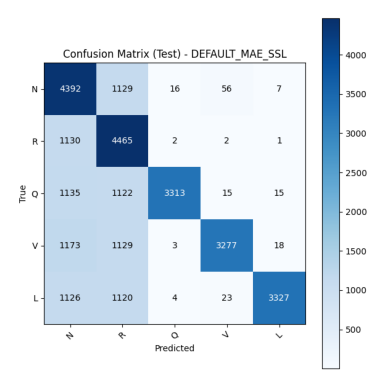

Finished. Outputs saved inside MAE_SSL_BEATS/Default_MAE_SSL folder.


In [11]:
print('\n' + '='*80)
print('Starting DEFAULT MAE+SSL 5-Fold training...')
print('='*80)

default_cfg = DEFAULT_CONFIG
folds_default = run_5fold_training(default_cfg, default_run_name='default_mae_ssl')
summarize_folds(folds_default, 'DEFAULT_MAE_SSL')

# Collect aggregated preds/trues for default
all_preds = []
all_trues = []
for f, d in folds_default.items():
    all_preds.extend(d['preds'])
    all_trues.extend(d['trues'])

classification_report_and_cm(all_trues, all_preds, DEFAULT_CONFIG['dataset']['classes'], 'DEFAULT_MAE_SSL')

print('Finished. Outputs saved inside MAE_SSL_BEATS/Default_MAE_SSL folder.')  # ✅ CHANGED: Updated message

## 8.2. Hyperparameter Tuning MAE+SSL (Hyperparameter tuning + 5-Fold Training)

[I 2025-10-24 14:45:24,213] A new study created in memory with name: no-name-b6e14134-5338-4479-b437-362742a2b513


Starting HYPERPARAMETER TUNING...


/tmp/ipykernel_37/1040501178.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/tmp/ipykernel_37/1040501178.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/tmp/ipykernel_37/1040501178.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  mask_ratio = trial.suggest_uniform('mask_ratio', 0.1, 0.75)
/tmp/ipykernel_37/1040501178.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

Best trial: {'lr': 0.0011919044846127901, 'weight_decay': 0.0021719549389975384, 'dim': 128, 'n_heads': 4, 'mask_ratio': 0.5302625070220843, 'ssl_weight': 0.3900387125137227, 'temperature': 0.06943675431535937}
Running 5-fold with HPO best config...

Starting fold 1 - MAE+SSL Training

--- Phase 1: SSL Pretraining (20 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.3382 recon_loss=0.0014
Pretrain Epoch 2/20: contrastive_loss=3.5296 recon_loss=0.0002
Pretrain Epoch 3/20: contrastive_loss=2.9287 recon_loss=0.0001
Pretrain Epoch 4/20: contrastive_loss=2.3980 recon_loss=0.0001
Pretrain Epoch 5/20: contrastive_loss=2.0168 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=1.1439 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=1.0656 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=0.9937 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=0.9312 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=0.8845 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=0.8400 recon_loss=0.0000
Pretrain Epoch 17/20: contrastive_loss=0.7992 recon_loss=0.0000
Pretrain Epoch 18/20: contrastive_loss=0.7338 recon_loss=0.0000
Pretrain Epoch 19/20: contrastive_loss=0.7150 recon_loss=0.0000
Pretrain Epoch 20/20: contrastive_loss=0.6922 recon_loss=0.0000

--- Phase 2: Classification Fine-tuning (20 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.8448 recon_loss=0.0011
Pretrain Epoch 2/20: contrastive_loss=4.8440 recon_loss=0.0000
Pretrain Epoch 3/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 4/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 5/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 7/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=4.8442 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.8456 recon_loss=0.0008
Pretrain Epoch 2/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 3/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 4/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 5/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 7/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=4.8471 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=4.8442 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.8460 recon_loss=0.0010
Pretrain Epoch 2/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 3/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 4/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 5/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 7/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=4.8441 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=4.8442 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=4.8438 recon_loss=0.0014
Pretrain Epoch 2/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 3/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 4/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 5/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 6/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 7/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 8/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 9/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 10/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 11/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 12/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 13/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 14/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 15/20: contrastive_loss=4.8442 recon_loss=0.0000
Pretrain Epoch 16/20: contrastive_loss=4.8442 rec

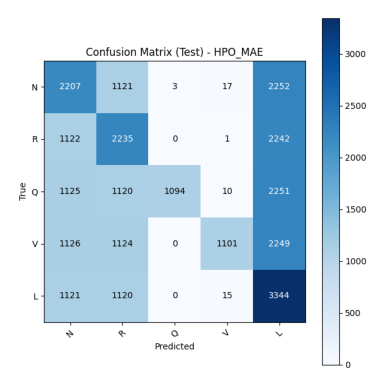

Finished. Outputs saved inside outputs/HPO_MAE folder.


In [12]:
# 2) Hyperparameter tuning + 5-Fold Training
if OPTUNA_AVAILABLE:
    print('Starting HYPERPARAMETER TUNING...')
    hpo_cfg = json.loads(json.dumps(DEFAULT_CONFIG))
    hpo_cfg, study = run_hyperparam_search(hpo_cfg, n_trials=20, timeout=600)
    print('Running 5-fold with HPO best config...')
    folds_hpo = run_5fold_training(hpo_cfg, default_run_name='hpo_mae_ssl')
    summarize_folds(folds_hpo, 'HPO_MAE_SSL')

    all_preds_hpo = []
    all_trues_hpo = []
    for f, d in folds_hpo.items():
        all_preds_hpo.extend(d['preds'])
        all_trues_hpo.extend(d['trues'])
    classification_report_and_cm(all_trues_hpo, all_preds_hpo, DEFAULT_CONFIG['dataset']['classes'], 'HPO_MAE')

else:
    print('Optuna not available. Skipping HPO run. To enable, install optuna.')

print('Finished. Outputs saved inside outputs/HPO_MAE folder.')

In [13]:
print('\n=== Comparison ===')
print('DEFAULT mean acc:', np.mean([d['val_acc'] for d in folds_default.values()]))
print('HPO mean acc:', np.mean([d['val_acc'] for d in folds_hpo.values()]))


=== Comparison ===
DEFAULT mean acc: 0.6705
HPO mean acc: 0.3564642857142857


# 9. Evaluate

## 9.1. Evaluate Utils

In [14]:
def plot_training_history_per_fold(fold_results, model_name, save_prefix):
    """Plot training history (loss and accuracy) for each fold separately"""

    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_mae_ssl' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_mae_ssl' else OUTPUT_DIRS['outputs']

    history_dir = OUTPUT_DIRS['default_history'] if save_prefix.lower() == 'default_mae_ssl' else \
        OUTPUT_DIRS['hpo_history'] if save_prefix.lower() == 'hpo_mae_ssl' else OUTPUT_DIRS['outputs']
    
    n_folds = len(fold_results)
    
    # Create subplots for loss and accuracy
    fig, axes = plt.subplots(2, n_folds, figsize=(5*n_folds, 10))
    if n_folds == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{model_name} - Training History per Fold\n\n', fontsize=16, y=0.95)
    
    for i, (fold_num, fold_data) in enumerate(fold_results.items()):
        history = fold_data['history']
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Plot Loss
        axes[0, i].plot(epochs, history['train_loss'], 'b-', label='Train Loss', marker='o', markersize=3)
        axes[0, i].plot(epochs, history['val_loss'], 'red', label='Val Loss', marker='s', markersize=3)
        axes[0, i].set_title(f'Fold {fold_num} - Loss')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Plot Accuracy
        axes[1, i].plot(epochs, history['train_acc'], 'b-', label='Train Acc', marker='o', markersize=3)
        axes[1, i].plot(epochs, history['val_acc'], 'red', label='Val Acc', marker='s', markersize=3)
        axes[1, i].set_title(f'Fold {fold_num} - Accuracy')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Accuracy')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f'{history_dir}/{save_prefix}_training_history_per_fold.png', dpi=300, bbox_inches='tight')
    plt.close()

def get_fold_predictions_detailed(fold_results, cfg, fold_num, dataset_type='train'):
    """Get predictions and true labels for a specific fold and dataset type"""
    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
    
    for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        if current_fold + 1 == fold_num:
            if dataset_type == 'train':
                subset_idx = train_idx
            else:  # validation
                subset_idx = val_idx
                
            subset = Subset(dataset, subset_idx)
            loader = DataLoader(subset, batch_size=cfg['training']['batch_size'], 
                              shuffle=False, collate_fn=collate_ecg, 
                              num_workers=cfg['training']['num_workers'])
            
            # Load model
            sample_x, _ = dataset[subset_idx[0]]
            L = sample_x.shape[0]
            patch_size = cfg['model']['patch_size']
            num_patches = (L + patch_size - 1) // patch_size
            
            model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
            model.load_state_dict(fold_results[fold_num]['model_state_dict'])
            
            # Get predictions
            _, _, preds, trues = validate(model, loader, device)
            return preds, trues
    
    return [], []

def plot_confusion_matrix_heatmap(y_true, y_pred, classes, title, save_path, cmap='Blues'):
    """Create confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return cm

def generate_classification_reports_per_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Generate classification reports for each fold (train and validation)"""
    reports = {
        'train': {},
        'val': {}
    }
    
    print(f"\n{'='*80}")
    print(f"{model_name} - CLASSIFICATION REPORTS PER FOLD")
    print('='*80)
    
    for fold_num in fold_results.keys():
        print(f"\n### FOLD {fold_num} ###")
        
        # Train predictions
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        if len(train_preds) > 0:
            train_report = classification_report(train_trues, train_preds, target_names=classes, output_dict=True)
            reports['train'][fold_num] = train_report
            
            print(f"\n--- FOLD {fold_num} TRAIN CLASSIFICATION REPORT ---")
            print(classification_report(train_trues, train_preds, target_names=classes))
        
        # Validation predictions (from stored results)
        val_preds = fold_results[fold_num]['preds']
        val_trues = fold_results[fold_num]['trues']
        val_report = classification_report(val_trues, val_preds, target_names=classes, output_dict=True)
        reports['val'][fold_num] = val_report
        
        print(f"\n--- FOLD {fold_num} VALIDATION CLASSIFICATION REPORT ---")
        print(classification_report(val_trues, val_preds, target_names=classes))
    
    return reports

def generate_confusion_matrices_per_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Generate confusion matrix for each fold (train and validation)"""
    print(f"\n{'='*80}")
    print(f"{model_name} - CONFUSION MATRIX PER FOLD")
    print('='*80)

    models_dir = OUTPUT_DIRS['default_models'] if save_prefix.lower() == 'default_mae' else \
        OUTPUT_DIRS['hpo_models'] if save_prefix.lower() == 'hpo_mae' else 'outputs'

    
    confusion_matrices = {
        'train': {},
        'val': {}
    }
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_mae' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_mae' else 'outputs'
    
    for fold_num in fold_results.keys():
        print(f"\n### FOLD {fold_num} CONFUSION MATRIX ###")
        
        # Train confusion matrix
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        if len(train_preds) > 0:
            train_cm = plot_confusion_matrix_heatmap(
                train_trues, train_preds, classes,
                f'{model_name} - Fold {fold_num} Train Confusion Matrix',
                f'{matrix_dir}/{save_prefix}_fold{fold_num}_train_confusion_matrix.png',
                cmap='Greens'
            )
            confusion_matrices['train'][fold_num] = train_cm
            print(f"Fold {fold_num} Train Confusion Matrix:")
            # print(train_cm)

            
            img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_train_confusion_matrix.png')
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        
        # Validation confusion matrix
        val_preds = fold_results[fold_num]['preds']
        val_trues = fold_results[fold_num]['trues']
        val_cm = plot_confusion_matrix_heatmap(
            val_trues, val_preds, classes,
            f'{model_name} - Fold {fold_num} Validation Confusion Matrix',
            f'{matrix_dir}/{save_prefix}_fold{fold_num}_val_confusion_matrix.png',
            cmap='Reds'
        )
        confusion_matrices['val'][fold_num] = val_cm
        print(f"Fold {fold_num} Validation Confusion Matrix:")
        # print(val_cm)
        
        img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_val_confusion_matrix.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    return confusion_matrices

def evaluate_test_set_for_fold(model_path, cfg, test_dirs, classes, fold_num, model_name, save_prefix):
    """Evaluate a specific fold model on test set"""
    device = cfg['training']['device']

    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_mae' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_mae' else 'outputs'
    
    # Load test dataset
    test_dataset = ECGBeatDataset(test_dirs, classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    # Load model
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Evaluate
    test_loss, test_acc, test_preds, test_trues = validate(model, test_loader, device)
    
    # Generate classification report
    print(f"\n--- FOLD {fold_num} TEST CLASSIFICATION REPORT ---")
    test_report = classification_report(test_trues, test_preds, target_names=classes)
    print(test_report)
    
    # Generate confusion matrix
    test_cm = plot_confusion_matrix_heatmap(
        test_trues, test_preds, classes,
        f'{model_name} - Fold {fold_num} Test Confusion Matrix',
        f'{matrix_dir}/{save_prefix}_fold{fold_num}_test_confusion_matrix.png',
        cmap='Greens'
    )
    print(f"Fold {fold_num} Test Confusion Matrix:")
    # print(test_cm)

    img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_test_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'predictions': test_preds,
        'true_labels': test_trues,
        'classification_report': classification_report(test_trues, test_preds, target_names=classes, output_dict=True),
        'confusion_matrix': test_cm
    }

def create_enhanced_excel_export(fold_results_default, fold_results_hpo, default_cfg, hpo_cfg, 
                               best_fold_default, best_fold_hpo, classes, filename='outputs/enhanced_metrics_comparison.xlsx'):
    """Enhanced Excel export with all requested metrics"""
    
    def create_fold_metrics_df(fold_results, cfg, model_name):
        """Create comprehensive metrics dataframe for all folds"""
        data = []
        
        for fold_num in fold_results.keys():
            # Get train metrics
            train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
            
            if len(train_preds) > 0:
                train_report = classification_report(train_trues, train_preds, target_names=classes, output_dict=True)
                
                # Add per-class metrics
                for class_name in classes:
                    if class_name in train_report:
                        data.append({
                            'Model': model_name,
                            'Dataset': 'Train',
                            'Fold': fold_num,
                            'Class': class_name,
                            'Precision': train_report[class_name]['precision'],
                            'Recall': train_report[class_name]['recall'],
                            'F1-Score': train_report[class_name]['f1-score'],
                            'Support': train_report[class_name]['support']
                        })
                
                # Add macro/weighted averages
                for avg_type in ['macro avg', 'weighted avg']:
                    if avg_type in train_report:
                        data.append({
                            'Model': model_name,
                            'Dataset': 'Train',
                            'Fold': fold_num,
                            'Class': avg_type,
                            'Precision': train_report[avg_type]['precision'],
                            'Recall': train_report[avg_type]['recall'],
                            'F1-Score': train_report[avg_type]['f1-score'],
                            'Support': train_report[avg_type]['support']
                        })
            
            # Get validation metrics
            val_preds = fold_results[fold_num]['preds']
            val_trues = fold_results[fold_num]['trues']
            val_report = classification_report(val_trues, val_preds, target_names=classes, output_dict=True)
            
            # Add per-class validation metrics
            for class_name in classes:
                if class_name in val_report:
                    data.append({
                        'Model': model_name,
                        'Dataset': 'Validation',
                        'Fold': fold_num,
                        'Class': class_name,
                        'Precision': val_report[class_name]['precision'],
                        'Recall': val_report[class_name]['recall'],
                        'F1-Score': val_report[class_name]['f1-score'],
                        'Support': val_report[class_name]['support']
                    })
            
            # Add macro/weighted averages for validation
            for avg_type in ['macro avg', 'weighted avg']:
                if avg_type in val_report:
                    data.append({
                        'Model': model_name,
                        'Dataset': 'Validation',
                        'Fold': fold_num,
                        'Class': avg_type,
                        'Precision': val_report[avg_type]['precision'],
                        'Recall': val_report[avg_type]['recall'],
                        'F1-Score': val_report[avg_type]['f1-score'],
                        'Support': val_report[avg_type]['support']
                    })
        
        return pd.DataFrame(data)
    
    # Create dataframes
    df_default = create_fold_metrics_df(fold_results_default, default_cfg, 'Default MAE')
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Default MAE metrics
        df_default.to_excel(writer, sheet_name='Default_MAE_SSL_All_Folds', index=False)
        
        # HPO MAE metrics (if available)
        if fold_results_hpo is not None:
            df_hpo = create_fold_metrics_df(fold_results_hpo, hpo_cfg, 'HPO MAE')
            df_hpo.to_excel(writer, sheet_name='HPO_MAE_All_Folds', index=False)
        
        # Best fold test results for Default MAE
        if best_fold_default:
            print(f"\nEvaluating Default MAE best fold ({best_fold_default}) on test set...")
            best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_mae_ssl_fold{best_fold_default}.pth'
            test_results_default = evaluate_test_set_for_fold(
                best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], 
                classes, best_fold_default, 'Default MAE', 'default_mae'
            )
            
            # Create test results dataframe
            test_data_default = []
            test_report = test_results_default['classification_report']
            
            for class_name in classes + ['macro avg', 'weighted avg']:
                if class_name in test_report:
                    test_data_default.append({
                        'Model': 'Default MAE',
                        'Best_Fold': best_fold_default,
                        
                        'Class': class_name,
                        'Precision': test_report[class_name]['precision'],
                        'Recall': test_report[class_name]['recall'],
                        'F1-Score': test_report[class_name]['f1-score'],
                        'Support': test_report[class_name]['support']
                    })
            
            df_test_default = pd.DataFrame(test_data_default)
            df_test_default.to_excel(writer, sheet_name='Default_MAE_SSL_Best_Test', index=False)
        
        # Best fold test results for HPO MAE
        if fold_results_hpo is not None and best_fold_hpo:
            print(f"\nEvaluating HPO MAE best fold ({best_fold_hpo}) on test set...")
            best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_mae_fold{best_fold_hpo}.pth'
            test_results_hpo = evaluate_test_set_for_fold(
                best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], 
                classes, best_fold_hpo, 'HPO MAE', 'hpo_mae'
            )
            
            # Create test results dataframe
            test_data_hpo = []
            test_report_hpo = test_results_hpo['classification_report']
            
            for class_name in classes + ['macro avg', 'weighted avg']:
                if class_name in test_report_hpo:
                    test_data_hpo.append({
                        'Model': 'HPO MAE',
                        'Best_Fold': best_fold_hpo,
                        'Class': class_name,
                        'Precision': test_report_hpo[class_name]['precision'],
                        'Recall': test_report_hpo[class_name]['recall'],
                        'F1-Score': test_report_hpo[class_name]['f1-score'],
                        'Support': test_report_hpo[class_name]['support']
                    })
            
            df_test_hpo = pd.DataFrame(test_data_hpo)
            df_test_hpo.to_excel(writer, sheet_name='HPO_MAE_Best_Test', index=False)
    
    print(f"\nEnhanced metrics exported to {filename}")

# Find best folds
def find_best_fold(fold_results):
    """Find best fold based on validation accuracy"""
    best_fold = None
    best_acc = 0
    
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    return best_fold, best_acc

In [15]:
def evaluate_model_on_test_set(model_path, cfg, test_dirs, classes):
    """Evaluasi model pada test set"""
    device = cfg['training']['device']
    
    # Load test dataset
    test_dataset = ECGBeatDataset(test_dirs, classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    # Load model
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Evaluate
    test_loss, test_acc, test_preds, test_trues = validate(model, test_loader, device)
    
    return test_loss, test_acc, test_preds, test_trues

def get_train_predictions(fold_results, cfg):
    """Mendapatkan prediksi untuk training set dari setiap fold"""
    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    all_train_preds = []
    all_train_trues = []
    
    for fold, fold_data in fold_results.items():
        # Recreate the same train/val split
        X = list(range(len(dataset)))
        y = dataset.labels
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
        
        for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            if current_fold + 1 == fold:  # Match the fold
                train_subset = Subset(dataset, train_idx)
                train_loader = DataLoader(train_subset, batch_size=cfg['training']['batch_size'], 
                                        shuffle=False, collate_fn=collate_ecg, 
                                        num_workers=cfg['training']['num_workers'])
                
                # Load model
                sample_x, _ = dataset[train_idx[0]]
                L = sample_x.shape[0]
                patch_size = cfg['model']['patch_size']
                num_patches = (L + patch_size - 1) // patch_size
                
                model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
                model.load_state_dict(fold_data['model_state_dict'])
                
                # Get predictions
                _, _, train_preds, train_trues = validate(model, train_loader, device)
                all_train_preds.extend(train_preds)
                all_train_trues.extend(train_trues)
                break
    
    return all_train_preds, all_train_trues

def find_best_fold(fold_results):
    """Menemukan fold terbaik berdasarkan validation accuracy"""
    best_fold = None
    best_acc = 0
    
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    return best_fold, best_acc

def display_fold_metrics(fold_results, model_name):
    """Menampilkan metrik untuk setiap fold"""
    print(f"\n=== {model_name} - Metrics per Fold ===")
    print("Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)")
    print("-" * 70)
    
    for fold, data in fold_results.items():
        history = data['history']
        last_train_acc = history['val_acc'][-1] if history['val_acc'] else "N/A"  # Using val_acc as proxy
        last_train_loss = history['train_loss'][-1] if history['train_loss'] else "N/A"
        
        print(f"{fold:4d} | {data['val_acc']:7.4f} | {data['val_loss']:8.4f} | {last_train_acc:13.4f} | {last_train_loss:15.4f}")


def compare_configurations(default_cfg, hpo_cfg=None, output_dir=None):
    """Membandingkan konfigurasi default dan hasil HPO, lalu ekspor ke Excel"""
    print("\n=== Parameter Comparison ===")
    print("Parameter                | Default Config | Best HPO Config")
    print("-" * 60)
    
    data = []
    
    def add_row(param, default_value, hpo_value):
        data.append({
            'Parameter': param,
            'Default Config': default_value,
            'Best HPO Config': hpo_value if hpo_cfg else 'N/A'
        })
    
    # Training parameters
    add_row("Device", default_cfg['training']['device'], hpo_cfg['training']['device'] if hpo_cfg else None)
    add_row("Epoch", default_cfg['training']['num_epochs'], hpo_cfg['training']['num_epochs'] if hpo_cfg else None)
    add_row("Batch Size", default_cfg['training']['batch_size'], hpo_cfg['training']['batch_size'] if hpo_cfg else None)
    add_row("Learning Rate", default_cfg['training']['learning_rate'], hpo_cfg['training']['learning_rate'] if hpo_cfg else None)
    add_row("Weight Decay", default_cfg['training']['weight_decay'], hpo_cfg['training']['weight_decay'] if hpo_cfg else None)
    
    # Model parameters
    add_row("Model Dimension", default_cfg['model']['dim'], hpo_cfg['model']['dim'] if hpo_cfg else None)
    add_row("Number of Heads", default_cfg['model']['n_heads'], hpo_cfg['model']['n_heads'] if hpo_cfg else None)
    add_row("Mask Ratio", default_cfg['model']['mask_ratio'], hpo_cfg['model']['mask_ratio'] if hpo_cfg else None)
    add_row("Dropout", default_cfg['model']['dropout'], hpo_cfg['model']['dropout'] if hpo_cfg else None)

    # Cetak hasil ke console
    for row in data:
        print(f"{row['Parameter']:<24} | {str(row['Default Config']):14s} | {str(row['Best HPO Config']):15s}")

    # Ekspor ke Excel jika output_dir diberikan
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "parameter_comparison.xlsx")
        df = pd.DataFrame(data)
        df.to_excel(output_path, index=False)
        print(f"\n✅ Hasil perbandingan disimpan ke: {output_path}")

In [16]:
def calculate_detailed_metrics_updated(y_true, y_pred, classes):
    """
    Calculate detailed metrics: Per-Class Accuracy (corrected formula), Sensitivity (Recall), Specificity, F1-Score
    for each class and overall
    """
    # Calculate per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(len(classes)))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate per-class accuracy: correct predictions for each class / total samples of that class
    per_class_accuracy = []
    specificity = []
    
    for i in range(len(classes)):
        # Per-class accuracy
        total = cm.sum()
        tp = cm[i, i]  # True positives (diagonal element)
        fn = cm[i, :].sum() - tp  # False negatives (row sum minus diagonal)
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        # fp = cm[:,i].sum() - tp
        # tn = total - (tp+fp+fn)
 
        per_class_acc = (tp+tn) / (total)  if (tp + fn) > 0 else 0
        per_class_accuracy.append(per_class_acc)
        
        # Specificity: TN / (TN + FP)
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)
    
    # Calculate overall accuracy (traditional way for "All" class)
    overall_accuracy = np.mean(per_class_accuracy)
    
    # Calculate macro averages
    macro_sensitivity = np.mean(recall)
    macro_specificity = np.mean(specificity)
    macro_f1 = np.mean(f1)
    
    return {
        'per_class': {
            'accuracy': per_class_accuracy,  # Updated per-class accuracy calculation
            'sensitivity': recall,
            'specificity': specificity,
            'f1_score': f1
        },
        'overall': {
            'accuracy': overall_accuracy,  # Overall accuracy remains traditional calculation
            'sensitivity': macro_sensitivity,
            'specificity': macro_specificity,
            'f1_score': macro_f1
        }
    }

def get_test_metrics_for_best_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Get test metrics for the best fold"""

    models_dir = OUTPUT_DIRS['default_models'] if save_prefix.lower() == 'default_mae_ssl' else \
        OUTPUT_DIRS['hpo_models'] if save_prefix.lower() == 'hpo_mae_ssl' else OUTPUT_DIRS['outputs']
    
    # Find best fold
    best_fold = None
    best_acc = 0
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    if best_fold is None:
        return None, None
        
    # Load and evaluate test set
    device = cfg['training']['device']
    test_dataset = ECGBeatDataset(cfg['dataset']['test_dirs'], classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    # Load model for best fold
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model_path = f'{models_dir}/{save_prefix}_fold{best_fold}.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Get test predictions
    _, _, test_preds, test_trues = validate(model, test_loader, device)
    
    # Calculate detailed metrics with updated accuracy calculation
    metrics = calculate_detailed_metrics_updated(test_trues, test_preds, classes)
    
    # Create results list
    results = []
    
    # Add per-class results
    for i, class_name in enumerate(classes):
        results.append({
            'Best_Fold': best_fold,
            'Class': class_name,
            'Accuracy': f"{metrics['per_class']['accuracy'][i]:.4f}",
            'Sensitivity': f"{metrics['per_class']['sensitivity'][i]:.4f}",
            'Specificity': f"{metrics['per_class']['specificity'][i]:.4f}",
            'F1-Score': f"{metrics['per_class']['f1_score'][i]:.4f}"
        })
    
    # Add overall result
    results.append({
        'Best_Fold': best_fold,
        'Class': 'All',
        'Accuracy': f"{metrics['overall']['accuracy']:.4f}",  # Traditional accuracy for "All"
        'Sensitivity': f"{metrics['overall']['sensitivity']:.4f}",
        'Specificity': f"{metrics['overall']['specificity']:.4f}",
        'F1-Score': f"{metrics['overall']['f1_score']:.4f}"
    })
    
    return pd.DataFrame(results), best_fold

def get_fold_predictions_and_trues(fold_results, cfg, fold_num, dataset_type='train'):
    """
    Get predictions and true labels for a specific fold and dataset type
    """
    device = cfg['training']['device']
    dataset = ECGBeatDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
    
    for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        if current_fold + 1 == fold_num:
            if dataset_type == 'train':
                subset_idx = train_idx
            else:  # validation
                subset_idx = val_idx
                
            subset = Subset(dataset, subset_idx)
            loader = DataLoader(subset, batch_size=cfg['training']['batch_size'], 
                              shuffle=False, collate_fn=collate_ecg, 
                              num_workers=cfg['training']['num_workers'])
            
            # Load model
            sample_x, _ = dataset[subset_idx[0]]
            L = sample_x.shape[0]
            patch_size = cfg['model']['patch_size']
            num_patches = (L + patch_size - 1) // patch_size
            
            model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
            model.load_state_dict(fold_results[fold_num]['model_state_dict'])
            
            # Get predictions
            _, _, preds, trues = validate(model, loader, device)
            return preds, trues
    
    return [], []


def create_detailed_metrics_table_updated(fold_results, cfg, model_name, classes):
    """
    Create detailed metrics table for all folds with updated per-class accuracy calculation
    """
    results = []
    
    # Process each fold
    for fold_num in fold_results.keys():
        print(f"Processing {model_name} - Fold {fold_num}...")
        
        # Get train predictions for this fold
        train_preds, train_trues = get_fold_predictions_and_trues(fold_results, cfg, fold_num, 'train')
        
        if len(train_preds) > 0 and len(train_trues) > 0:
            # Calculate metrics for this fold with updated accuracy calculation
            metrics = calculate_detailed_metrics_updated(train_trues, train_preds, classes)
            
            # Add per-class results
            for i, class_name in enumerate(classes):
                results.append({
                    'Fold': f'Fold {fold_num}',
                    'Class': class_name,
                    'Accuracy': f"{metrics['per_class']['accuracy'][i]:.4f}",
                    'Sensitivity': f"{metrics['per_class']['sensitivity'][i]:.4f}",
                    'Specificity': f"{metrics['per_class']['specificity'][i]:.4f}",
                    'F1-Score': f"{metrics['per_class']['f1_score'][i]:.4f}"
                })
            
            # Add overall result for this fold
            results.append({
                'Fold': f'Fold {fold_num}',
                'Class': 'All',
                'Accuracy': f"{metrics['overall']['accuracy']:.4f}",
                'Sensitivity': f"{metrics['overall']['sensitivity']:.4f}",
                'Specificity': f"{metrics['overall']['specificity']:.4f}",
                'F1-Score': f"{metrics['overall']['f1_score']:.4f}"
            })
    
    # Calculate across all folds summary
    all_train_preds = []
    all_train_trues = []
    
    for fold_num in fold_results.keys():
        train_preds, train_trues = get_fold_predictions_and_trues(fold_results, cfg, fold_num, 'train')
        all_train_preds.extend(train_preds)
        all_train_trues.extend(train_trues)
    
    if len(all_train_preds) > 0:
        overall_metrics = calculate_detailed_metrics_updated(all_train_trues, all_train_preds, classes)
        results.append({
            'Fold': 'Across 5 folds',
            'Class': 'All',
            'Accuracy': f"{overall_metrics['overall']['accuracy']:.4f}",
            'Sensitivity': f"{overall_metrics['overall']['sensitivity']:.4f}",
            'Specificity': f"{overall_metrics['overall']['specificity']:.4f}",
            'F1-Score': f"{overall_metrics['overall']['f1_score']:.4f}"
        })
    
    return pd.DataFrame(results)

def display_metrics_table(df, title):
    """Display metrics table in a formatted way"""
    print(f"\n{'='*80}")
    print(f"{title:^80}")
    print('='*80)
    
    # Group by fold for better display
    current_fold = None
    for _, row in df.iterrows():
        if row['Fold'] != current_fold:
            if current_fold is not None:
                print('-'*80)
            current_fold = row['Fold']
            print(f"\n{row['Fold']:<15} {row['Class']:<5} {row['Accuracy']:<10} {row['Sensitivity']:<12} {row['Specificity']:<12} {row['F1-Score']:<10}")
        else:
            print(f"{'':15} {row['Class']:<5} {row['Accuracy']:<10} {row['Sensitivity']:<12} {row['Specificity']:<12} {row['F1-Score']:<10}")

def save_metrics_to_excel_enhanced_updated(df_default, df_hpo=None, fold_results_default=None, fold_results_hpo=None, 
                                         default_cfg=None, hpo_cfg=None, classes=None, filename=f'{OUTPUT_DIRS["outputs"]}/detailed_metrics_comparison.xlsx'):
    """Save metrics tables to Excel file with additional sheets including test results for best folds"""
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Original sheets with updated accuracy calculation
        df_default.to_excel(writer, sheet_name='Default_Train_MAE_SSL', index=False)
        if df_hpo is not None:
            df_hpo.to_excel(writer, sheet_name='Tuning_Train_MAE_SSL', index=False)
        
        # New sheet: Default_Test_MAE (test results for best Default fold)
        if fold_results_default is not None and default_cfg is not None and classes is not None:
            print("Generating Default_Test_MAE_SSL sheet...")
            df_default_test, best_fold_default = get_test_metrics_for_best_fold(
                fold_results_default, default_cfg, classes, "Default MAE+SSL", "default_mae_ssl"
            )
            if df_default_test is not None:
                df_default_test.to_excel(writer, sheet_name='Default_Test_MAE_SSL', index=False)
                print(f"Default_Test_MAE sheet created successfully for best fold {best_fold_default}.")
            else:
                print("Failed to create Default_Test_MAE_SSL sheet.")
        
        # New sheet: Tuning_Test_MAE (test results for best HPO fold)
        if fold_results_hpo is not None and hpo_cfg is not None and classes is not None:
            print("Generating Tuning_Test_MAE_SSL sheet...")
            df_hpo_test, best_fold_hpo = get_test_metrics_for_best_fold(
                fold_results_hpo, hpo_cfg, classes, "HPO MAE+SSL", "hpo_mae_ssl"
            )
            if df_hpo_test is not None:
                df_hpo_test.to_excel(writer, sheet_name='Tuning_Test_MAE_SSL', index=False)
                print(f"Tuning_Test_MAE sheet created successfully for best fold {best_fold_hpo}.")
            else:
                print("Failed to create Tuning_Test_MAE_SSL sheet.")
    
    print(f"Enhanced metrics with updated accuracy calculation saved to {filename}")

## 9.2. Best Fold - Default MAE+SSL & HPO MAE+SSL

In [18]:
best_fold_default, best_acc_default = find_best_fold(folds_default)
print(f"\n=> Best Fold (Default MAE): Fold {best_fold_default} with accuracy {best_acc_default:.4f}")

display_fold_metrics(folds_default, "DEFAULT MAE")

best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_mae_ssl_fold{best_fold_default}.pth'
test_loss_default, test_acc_default, test_preds_default, test_trues_default = evaluate_model_on_test_set(
    best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():

    print()
    best_fold_hpo, best_acc_hpo = find_best_fold(folds_hpo)
    print(f"\n=> Best Fold (HPO MAE): Fold {best_fold_hpo} with accuracy {best_acc_hpo:.4f}")
    
    display_fold_metrics(folds_hpo, "HPO MAE")

    best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_mae_ssl_fold{best_fold_hpo}.pth'
    test_loss_hpo, test_acc_hpo, test_preds_hpo, test_trues_hpo = evaluate_model_on_test_set(
        best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
    )
    print(f"\n\n\n=== IMPROVEMENT SUMMARY ===")
    print(f"Improvement: {((best_acc_hpo - best_acc_default) / best_acc_default * 100):+.2f}% (validation)")
    print(f"Improvement: {((test_acc_hpo - test_acc_default) / test_acc_default * 100):+.2f}% (test)\n")


=> Best Fold (Default MAE): Fold 5 with accuracy 0.9866

=== DEFAULT MAE - Metrics per Fold ===
Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)
----------------------------------------------------------------------
   1 |  0.9809 |   0.0570 |        0.9809 |          0.0514
   2 |  0.2000 |   1.6095 |        0.2000 |          1.6105
   3 |  0.2000 |   1.6096 |        0.2000 |          1.6100
   4 |  0.9850 |   0.0535 |        0.9850 |          0.0408
   5 |  0.9866 |   0.0593 |        0.9866 |          0.0474


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(




=> Best Fold (HPO MAE): Fold 1 with accuracy 0.9823

=== HPO MAE - Metrics per Fold ===
Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)
----------------------------------------------------------------------
   1 |  0.9823 |   0.0627 |        0.9823 |          0.0556
   2 |  0.2000 |   1.6099 |        0.2000 |          1.6100
   3 |  0.2000 |   1.6098 |        0.2000 |          1.6098
   4 |  0.2000 |   1.6102 |        0.2000 |          1.6099
   5 |  0.2000 |   1.6095 |        0.2000 |          1.6097


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(





=== IMPROVEMENT SUMMARY ===
Improvement: -0.43% (validation)
Improvement: +0.13% (test)



## 9.3. Training History per Fold - Default MAE+SSL & HPO MAE+SSL


Generating training history Default MAE plots per fold...


Default MAE - Training History per Fold:


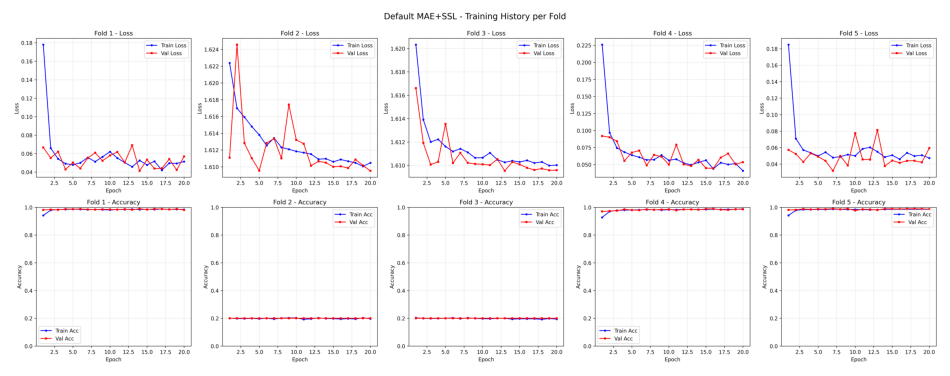

Generating training history HPO MAE plots per fold...


HPO MAE - Training History per Fold:


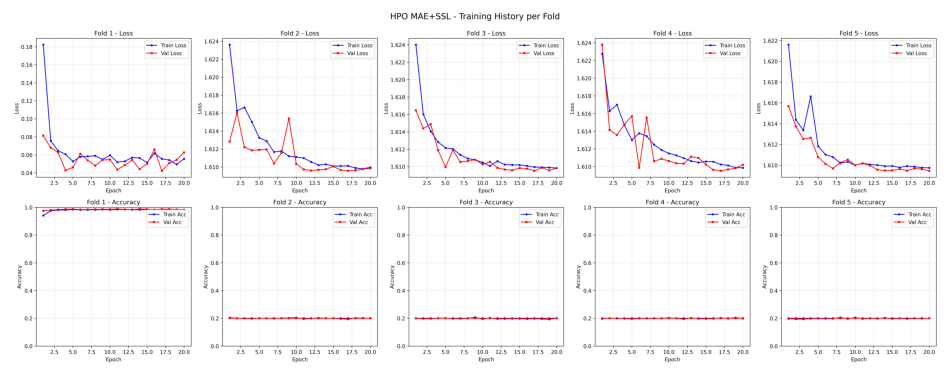

In [19]:
print("\nGenerating training history Default MAE plots per fold...")
plot_training_history_per_fold(folds_default, 'Default MAE+SSL', 'default_mae_ssl')

print("\n\nDefault MAE - Training History per Fold:")
img = mpimg.imread(f'{OUTPUT_DIRS["default_history"]}/default_mae_ssl_training_history_per_fold.png')
plt.figure(figsize=(12, 12)) 
plt.imshow(img)
plt.axis('off')
plt.show()

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():

    print("Generating training history HPO MAE plots per fold...")
    plot_training_history_per_fold(folds_hpo, 'HPO MAE+SSL', 'hpo_mae_ssl')

    print("\n\nHPO MAE - Training History per Fold:")
    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_history"]}/hpo_mae_ssl_training_history_per_fold.png')
    plt.figure(figsize=(12, 12)) 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 9.4. Classification Report per Fold - Default MAE+SSL & HPO MAE+SSL

In [20]:
print("\nGenerating classification Default MAE reports per fold...")
reports_default = generate_classification_reports_per_fold(
    folds_default, default_cfg, DEFAULT_CONFIG['dataset']['classes'], 'Default MAE', 'default_mae'
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating classification HPO MAE reports per fold...")
    reports_hpo = generate_classification_reports_per_fold(
        folds_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['classes'], 'HPO MAE', 'hpo_mae'
    )


Generating classification Default MAE reports per fold...

Default MAE - CLASSIFICATION REPORTS PER FOLD

### FOLD 1 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 1 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.96      1.00      0.98      4480
           R       1.00      1.00      1.00      4480
           Q       1.00      0.98      0.99      4480
           V       0.99      0.96      0.98      4480
           L       0.98      0.99      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 1 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.95      0.99      0.97      1120
           R       0.99      1.00      1.00      1120
           Q       1.00      0.97      0.98      1120
           V       0.98      0.96      0.97      1120
           L       0.98      0.99      0.99      1120

    accuracy                           0.98      5600
   macro avg       0.98      0.98     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetric


--- FOLD 2 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.00      0.00      0.00      4480
           R       0.20      1.00      0.33      4480
           Q       0.00      0.00      0.00      4480
           V       0.00      0.00      0.00      4480
           L       0.00      0.00      0.00      4480

    accuracy                           0.20     22400
   macro avg       0.04      0.20      0.07     22400
weighted avg       0.04      0.20      0.07     22400


--- FOLD 2 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.00      0.00      0.00      1120
           R       0.20      1.00      0.33      1120
           Q       0.00      0.00      0.00      1120
           V       0.00      0.00      0.00      1120
           L       0.00      0.00      0.00      1120

    accuracy                           0.20      5600
   macro avg       0.04      0.20     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetric


--- FOLD 3 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.20      1.00      0.33      4480
           R       0.00      0.00      0.00      4480
           Q       0.00      0.00      0.00      4480
           V       0.00      0.00      0.00      4480
           L       0.00      0.00      0.00      4480

    accuracy                           0.20     22400
   macro avg       0.04      0.20      0.07     22400
weighted avg       0.04      0.20      0.07     22400


--- FOLD 3 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.20      1.00      0.33      1120
           R       0.00      0.00      0.00      1120
           Q       0.00      0.00      0.00      1120
           V       0.00      0.00      0.00      1120
           L       0.00      0.00      0.00      1120

    accuracy                           0.20      5600
   macro avg       0.04      0.20     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 4 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.97      0.98      4480
           R       0.99      1.00      0.99      4480
           Q       0.99      0.99      0.99      4480
           V       0.98      0.99      0.98      4480
           L       0.99      0.99      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 4 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.98      0.97      0.98      1120
           R       0.99      0.99      0.99      1120
           Q       0.98      0.99      0.99      1120
           V       0.97      0.99      0.98      1120
           L       0.99      0.99      0.99      1120

    accuracy                           0.98      5600
   macro avg       0.99      0.98     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 5 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.97      0.98      4480
           R       1.00      1.00      1.00      4480
           Q       0.99      0.99      0.99      4480
           V       0.97      0.98      0.98      4480
           L       0.98      0.99      0.99      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 5 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.96      0.98      1120
           R       0.99      1.00      1.00      1120
           Q       1.00      1.00      1.00      1120
           V       0.96      0.98      0.97      1120
           L       0.99      0.99      0.99      1120

    accuracy                           0.99      5600
   macro avg       0.99      0.99     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 1 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.97      0.98      4480
           R       0.99      1.00      1.00      4480
           Q       1.00      0.99      0.99      4480
           V       0.97      0.98      0.98      4480
           L       0.97      0.99      0.98      4480

    accuracy                           0.99     22400
   macro avg       0.99      0.99      0.99     22400
weighted avg       0.99      0.99      0.99     22400


--- FOLD 1 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.99      0.97      0.98      1120
           R       1.00      1.00      1.00      1120
           Q       1.00      0.98      0.99      1120
           V       0.96      0.98      0.97      1120
           L       0.97      0.99      0.98      1120

    accuracy                           0.98      5600
   macro avg       0.98      0.98     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetric


--- FOLD 2 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.20      1.00      0.33      4480
           R       0.00      0.00      0.00      4480
           Q       0.00      0.00      0.00      4480
           V       0.00      0.00      0.00      4480
           L       0.00      0.00      0.00      4480

    accuracy                           0.20     22400
   macro avg       0.04      0.20      0.07     22400
weighted avg       0.04      0.20      0.07     22400


--- FOLD 2 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.20      1.00      0.33      1120
           R       0.00      0.00      0.00      1120
           Q       0.00      0.00      0.00      1120
           V       0.00      0.00      0.00      1120
           L       0.00      0.00      0.00      1120

    accuracy                           0.20      5600
   macro avg       0.04      0.20     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetric


--- FOLD 3 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.00      0.00      0.00      4480
           R       0.20      1.00      0.33      4480
           Q       0.00      0.00      0.00      4480
           V       0.00      0.00      0.00      4480
           L       0.00      0.00      0.00      4480

    accuracy                           0.20     22400
   macro avg       0.04      0.20      0.07     22400
weighted avg       0.04      0.20      0.07     22400


--- FOLD 3 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.00      0.00      0.00      1120
           R       0.20      1.00      0.33      1120
           Q       0.00      0.00      0.00      1120
           V       0.00      0.00      0.00      1120
           L       0.00      0.00      0.00      1120

    accuracy                           0.20      5600
   macro avg       0.04      0.20     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetric


--- FOLD 4 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.00      0.00      0.00      4480
           R       0.00      0.00      0.00      4480
           Q       0.00      0.00      0.00      4480
           V       0.00      0.00      0.00      4480
           L       0.20      1.00      0.33      4480

    accuracy                           0.20     22400
   macro avg       0.04      0.20      0.07     22400
weighted avg       0.04      0.20      0.07     22400


--- FOLD 4 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.00      0.00      0.00      1120
           R       0.00      0.00      0.00      1120
           Q       0.00      0.00      0.00      1120
           V       0.00      0.00      0.00      1120
           L       0.20      1.00      0.33      1120

    accuracy                           0.20      5600
   macro avg       0.04      0.20     

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 5 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.00      0.00      0.00      4480
           R       0.00      0.00      0.00      4480
           Q       0.00      0.00      0.00      4480
           V       0.00      0.00      0.00      4480
           L       0.20      1.00      0.33      4480

    accuracy                           0.20     22400
   macro avg       0.04      0.20      0.07     22400
weighted avg       0.04      0.20      0.07     22400


--- FOLD 5 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           N       0.00      0.00      0.00      1120
           R       0.00      0.00      0.00      1120
           Q       0.00      0.00      0.00      1120
           V       0.00      0.00      0.00      1120
           L       0.20      1.00      0.33      1120

    accuracy                           0.20      5600
   macro avg       0.04      0.20     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

## 9.5.  Confusion Matrix per Fold - Default MAE+SSL & HPO MAE+SSL


Generating Confusion Matrix Default MAE per fold...

Default MAE - CONFUSION MATRIX PER FOLD

### FOLD 1 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 1 Train Confusion Matrix:


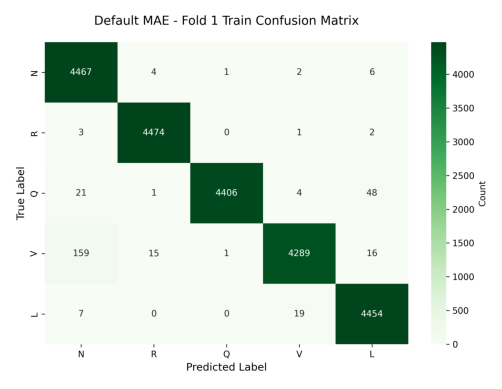

Fold 1 Validation Confusion Matrix:


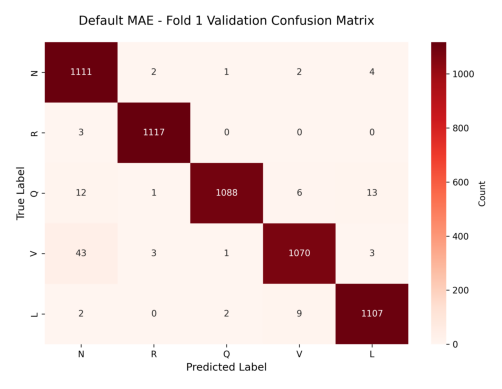


### FOLD 2 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 2 Train Confusion Matrix:


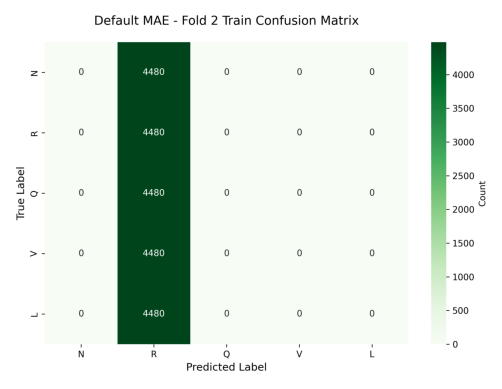

Fold 2 Validation Confusion Matrix:


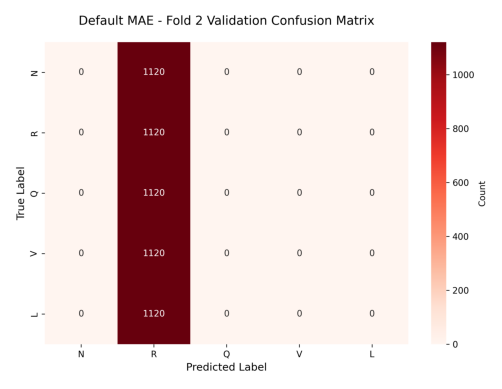


### FOLD 3 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 3 Train Confusion Matrix:


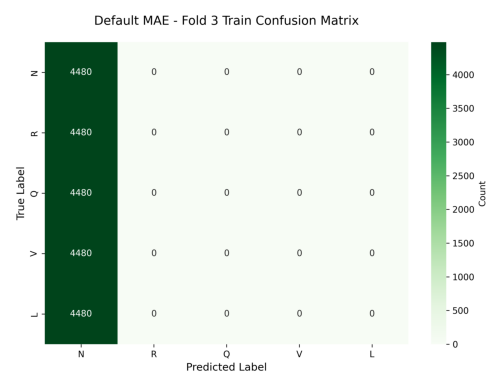

Fold 3 Validation Confusion Matrix:


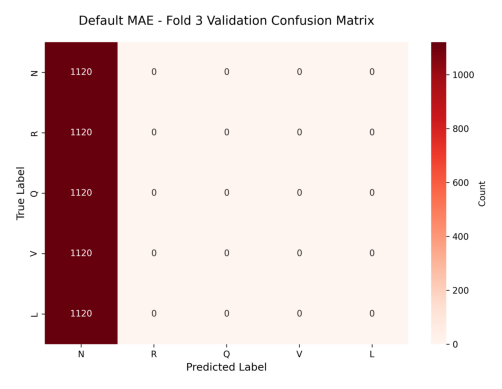


### FOLD 4 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 4 Train Confusion Matrix:


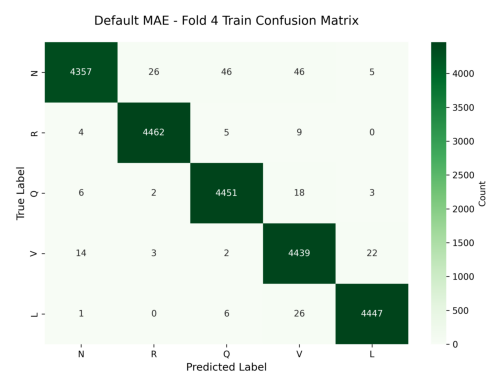

Fold 4 Validation Confusion Matrix:


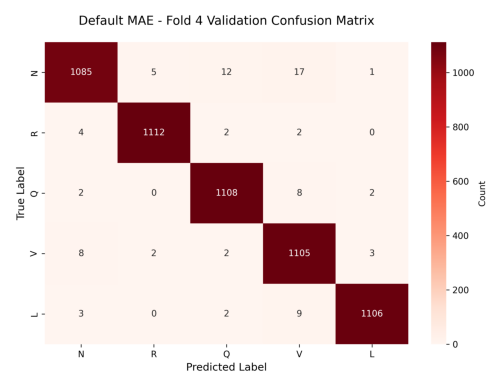


### FOLD 5 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 5 Train Confusion Matrix:


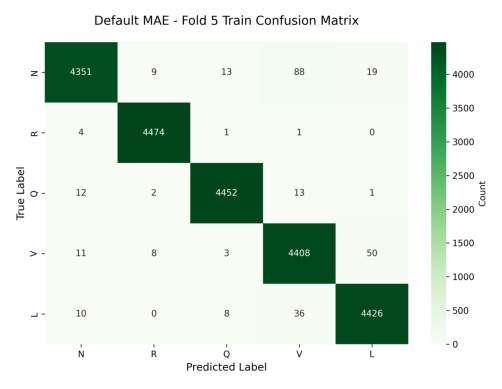

Fold 5 Validation Confusion Matrix:


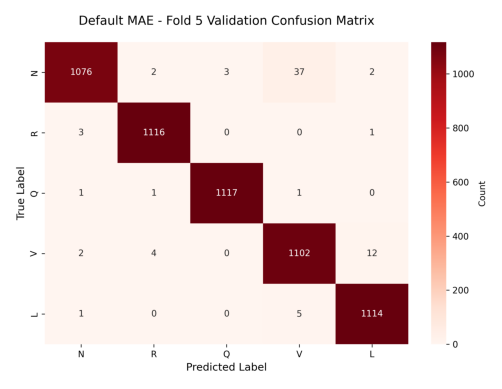


Generating Confusion Matrix HPO MAE per fold...

HPO MAE - CONFUSION MATRIX PER FOLD

### FOLD 1 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 1 Train Confusion Matrix:


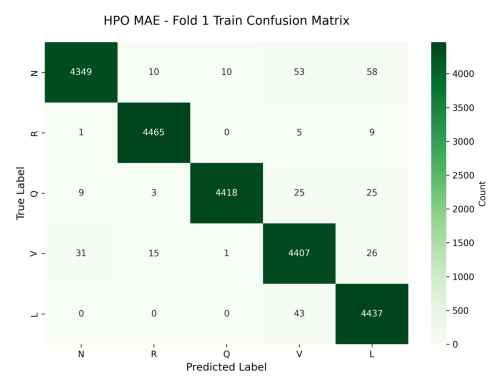

Fold 1 Validation Confusion Matrix:


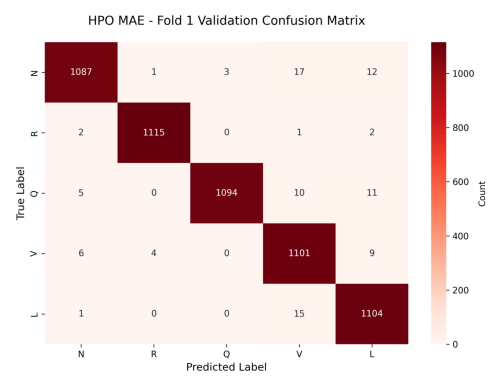


### FOLD 2 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 2 Train Confusion Matrix:


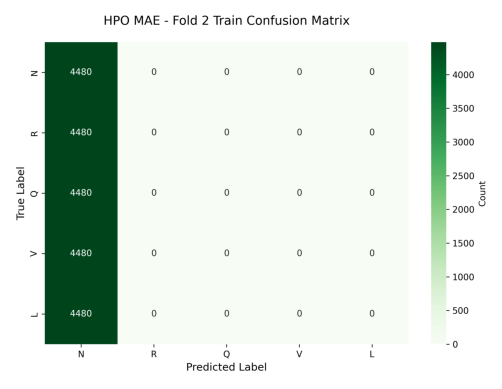

Fold 2 Validation Confusion Matrix:


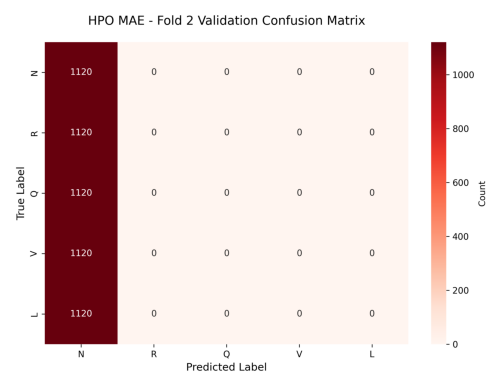


### FOLD 3 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 3 Train Confusion Matrix:


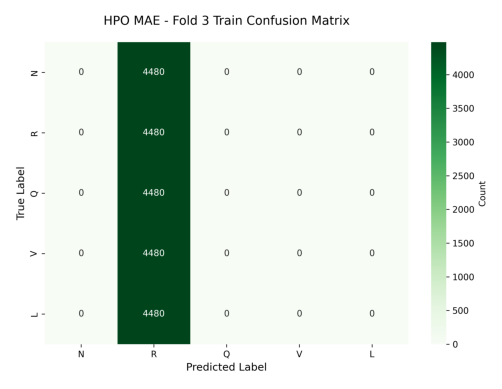

Fold 3 Validation Confusion Matrix:


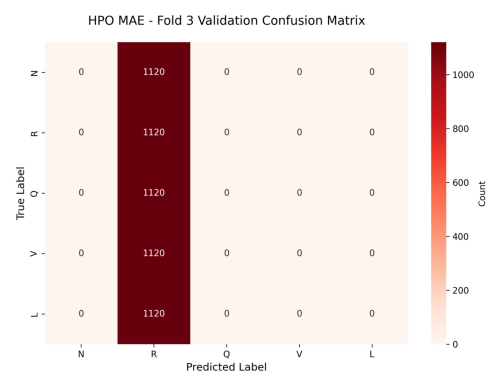


### FOLD 4 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 4 Train Confusion Matrix:


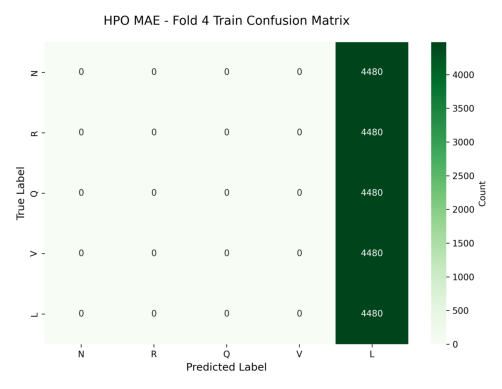

Fold 4 Validation Confusion Matrix:


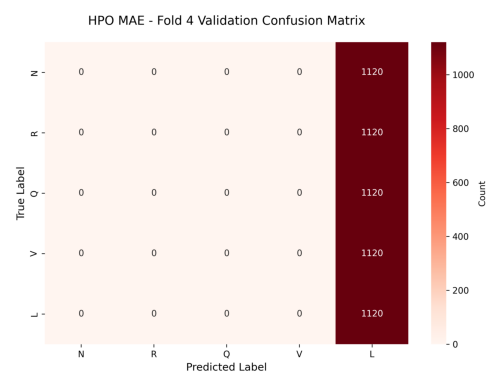


### FOLD 5 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 5 Train Confusion Matrix:


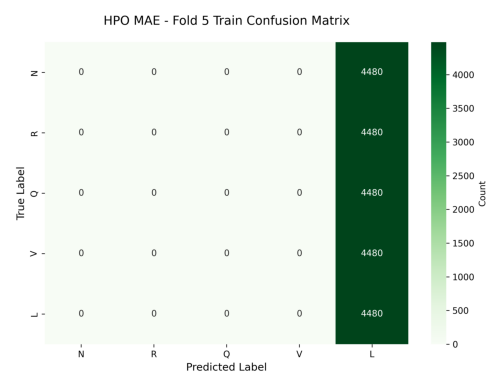

Fold 5 Validation Confusion Matrix:


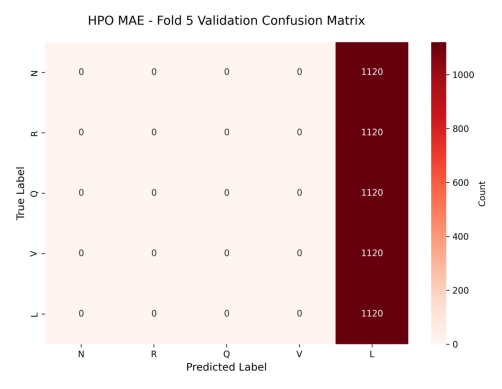

In [21]:
print("\nGenerating Confusion Matrix Default MAE per fold...")
cm_default = generate_confusion_matrices_per_fold(
    folds_default, default_cfg, DEFAULT_CONFIG['dataset']['classes'], 'Default MAE', 'default_mae'
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating Confusion Matrix HPO MAE per fold...")
    cm_hpo = generate_confusion_matrices_per_fold(
        folds_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['classes'], 'HPO MAE', 'hpo_mae'
    )

## 9.6. Best Fold Default MAE+SSL & HPO MAE+SSL - Train & Test Evaluation

### 9.6.1. Default MAE


Getting train predictions for Default MAE...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False beca


--- Classification Report Train Default MAE ---
              precision    recall  f1-score   support

           N       0.49      0.79      0.61     22400
           R       0.50      0.80      0.61     22400
           Q       0.99      0.59      0.74     22400
           V       0.98      0.59      0.73     22400
           L       0.99      0.59      0.74     22400

    accuracy                           0.67    112000
   macro avg       0.79      0.67      0.69    112000
weighted avg       0.79      0.67      0.69    112000

Generating Confusion Matrix Train Default MAE...
Confusion Matrix Train Default MAE:



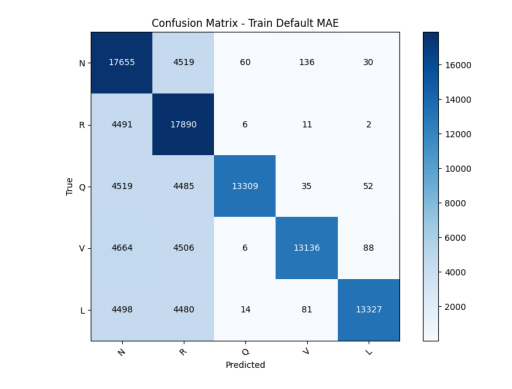


Evaluating Default MAE on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Test Accuracy Default MAE: 0.9806
Test Loss Default MAE: 0.0765

--- Classification Report Test Default MAE ---
              precision    recall  f1-score   support

           N       0.99      0.95      0.97      1400
           R       0.99      1.00      1.00      1400
           Q       0.99      0.98      0.99      1400
           V       0.95      0.98      0.96      1400
           L       0.98      0.99      0.99      1400

    accuracy                           0.98      7000
   macro avg       0.98      0.98      0.98      7000
weighted avg       0.98      0.98      0.98      7000

Generating Confusion Matrix Test Default MAE...
Confusion Matrix Test Default MAE:



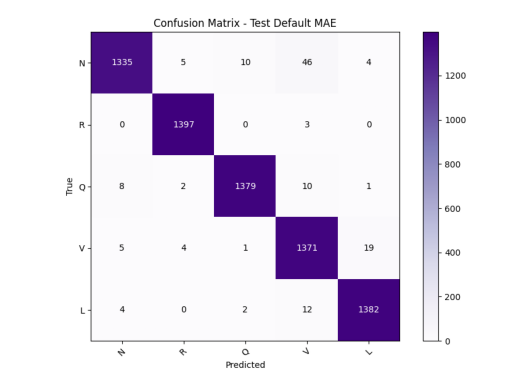

In [22]:
print("\nGetting train predictions for Default MAE...")
train_preds_default, train_trues_default = get_train_predictions(folds_default, default_cfg)

print("\n--- Classification Report Train Default MAE ---")
print(classification_report(train_trues_default, train_preds_default, target_names=DEFAULT_CONFIG['dataset']['classes']))

print("Generating Confusion Matrix Train Default MAE...")
cm_train_default = confusion_matrix(train_trues_default, train_preds_default)
print('Confusion Matrix Train Default MAE:\n')

plt.figure(figsize=(8,6))
plt.imshow(cm_train_default, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Train Default MAE')
plt.colorbar()

for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
    for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        plt.text(j, i, str(cm_train_default[i, j]),
                 ha="center", va="center",
                 color="white" if cm_train_default[i, j] > cm_train_default.max()/2 else "black")

tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIRS["default_matrix"]}/train_default_mae_ssl_confusion_matrix.png')
plt.close()

img = mpimg.imread(f'{OUTPUT_DIRS["default_matrix"]}/train_default_mae_ssl_confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()

print("\nEvaluating Default MAE on test set...")
best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_mae_ssl_fold{best_fold_default}.pth'
test_loss_default, test_acc_default, test_preds_default, test_trues_default = evaluate_model_on_test_set(
    best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
)

print(f"Test Accuracy Default MAE: {test_acc_default:.4f}")
print(f"Test Loss Default MAE: {test_loss_default:.4f}")

print("\n--- Classification Report Test Default MAE ---")
print(classification_report(test_trues_default, test_preds_default, target_names=DEFAULT_CONFIG['dataset']['classes']))

print("Generating Confusion Matrix Test Default MAE...")
cm_test_default = confusion_matrix(test_trues_default, test_preds_default)
print('Confusion Matrix Test Default MAE:\n')

plt.figure(figsize=(8,6))
plt.imshow(cm_test_default, interpolation='nearest', cmap='Purples')
plt.title('Confusion Matrix - Test Default MAE')
plt.colorbar()

for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
    for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        plt.text(j, i, str(cm_test_default[i, j]),
                 ha="center", va="center",
                 color="white" if cm_test_default[i, j] > cm_test_default.max()/2 else "black")

tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIRS["default_matrix"]}/test_default_mae_ssl_confusion_matrix.png')
plt.close()

img = mpimg.imread(f'{OUTPUT_DIRS["default_matrix"]}/test_default_mae_ssl_confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### 9.6.2. HPO MAE


Getting train predictions for HPO MAE...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False beca


--- Classification Report Train Hyperparameter Tuning MAE ---
              precision    recall  f1-score   support

           N       0.33      0.39      0.36     22400
           R       0.33      0.40      0.36     22400
           Q       1.00      0.20      0.33     22400
           V       0.97      0.20      0.33     22400
           L       0.27      0.60      0.37     22400

    accuracy                           0.36    112000
   macro avg       0.58      0.36      0.35    112000
weighted avg       0.58      0.36      0.35    112000

Generating Confusion Matrix Train HPO MAE...
Confusion Matrix Train HPO MAE:



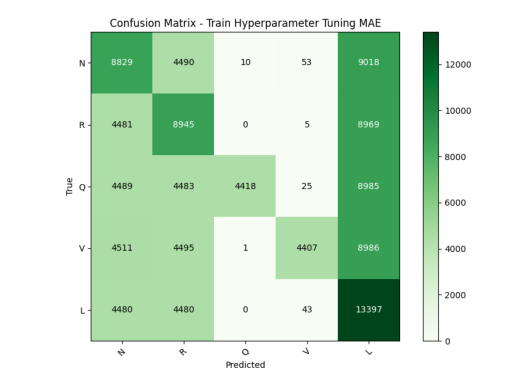


Evaluating HPO MAE on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Test Accuracy HPO MAE: 0.9819
Test Loss HPO MAE: 0.0634

--- Classification Report Test Hyperparameter Tuning MAE ---
              precision    recall  f1-score   support

           N       0.99      0.95      0.97      1400
           R       0.99      1.00      0.99      1400
           Q       1.00      0.98      0.99      1400
           V       0.96      0.99      0.97      1400
           L       0.97      0.99      0.98      1400

    accuracy                           0.98      7000
   macro avg       0.98      0.98      0.98      7000
weighted avg       0.98      0.98      0.98      7000

Generating Confusion Matrix Test HPO MAE...
Confusion Matrix Test HPO MAE:
 [[1335    3    6   26   30]
 [   0 1395    0    4    1]
 [   4    3 1374   11    8]
 [   6    4    0 1382    8]
 [   0    0    0   13 1387]]


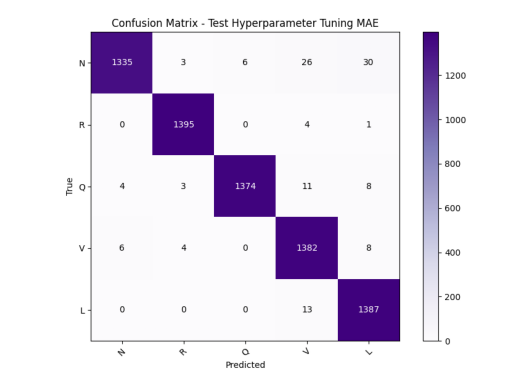

In [23]:
if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    
    print("\nGetting train predictions for HPO MAE...")
    train_preds_hpo, train_trues_hpo = get_train_predictions(folds_hpo, hpo_cfg)
    
    print("\n--- Classification Report Train Hyperparameter Tuning MAE ---")
    print(classification_report(train_trues_hpo, train_preds_hpo, target_names=DEFAULT_CONFIG['dataset']['classes']))
    
    print("Generating Confusion Matrix Train HPO MAE...")
    cm_train_hpo = confusion_matrix(train_trues_hpo, train_preds_hpo)
    print('Confusion Matrix Train HPO MAE:\n')
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm_train_hpo, interpolation='nearest', cmap='Greens')
    plt.title('Confusion Matrix - Train Hyperparameter Tuning MAE')
    plt.colorbar()
    
    for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
            plt.text(j, i, str(cm_train_hpo[i, j]),
                     ha="center", va="center",
                     color="white" if cm_train_hpo[i, j] > cm_train_hpo.max()/2 else "black")
    
    tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
    plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
    plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRS["hpo_matrix"]}/train_hpo_mae_confusion_matrix.png')
    plt.close()

    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_matrix"]}/train_hpo_mae_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print("\nEvaluating HPO MAE on test set...")
    best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_mae_ssl_fold{best_fold_hpo}.pth'
    test_loss_hpo, test_acc_hpo, test_preds_hpo, test_trues_hpo = evaluate_model_on_test_set(
        best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
    )
    
    print(f"Test Accuracy HPO MAE: {test_acc_hpo:.4f}")
    print(f"Test Loss HPO MAE: {test_loss_hpo:.4f}")
    
    print("\n--- Classification Report Test Hyperparameter Tuning MAE ---")
    print(classification_report(test_trues_hpo, test_preds_hpo, target_names=DEFAULT_CONFIG['dataset']['classes']))
    
    print("Generating Confusion Matrix Test HPO MAE...")
    cm_test_hpo = confusion_matrix(test_trues_hpo, test_preds_hpo)
    print('Confusion Matrix Test HPO MAE:\n', cm_test_hpo)
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm_test_hpo, interpolation='nearest', cmap='Purples')
    plt.title('Confusion Matrix - Test Hyperparameter Tuning MAE')
    plt.colorbar()
    
    for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
            plt.text(j, i, str(cm_test_hpo[i, j]),
                     ha="center", va="center",
                     color="white" if cm_test_hpo[i, j] > cm_test_hpo.max()/2 else "black")
    
    tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
    plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
    plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRS["hpo_matrix"]}/test_hpo_mae_confusion_matrix.png')
    plt.close()

    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_matrix"]}/test_hpo_mae_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 9.7. Default MAE+SSL & HPO MAE+SSL - Parameter Comparison

In [24]:
if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    compare_configurations(default_cfg, hpo_cfg, output_dir=OUTPUT_DIRS['outputs'])
else:
    compare_configurations(default_cfg, None, output_dir=OUTPUT_DIRS['outputs'])


=== Parameter Comparison ===
Parameter                | Default Config | Best HPO Config
------------------------------------------------------------
Device                   | cuda           | cuda           
Epoch                    | 20             | 20             
Batch Size               | 64             | 64             
Learning Rate            | 0.001          | 0.0011919044846127901
Weight Decay             | 0.0001         | 0.0021719549389975384
Model Dimension          | 128            | 128            
Number of Heads          | 4              | 4              
Mask Ratio               | 0.5            | 0.5302625070220843
Dropout                  | 0.1            | 0.1            

✅ Hasil perbandingan disimpan ke: MAE_SSL_BEATS/parameter_comparison.xlsx


## 9.8. Export Detailed Metrics Table to Excel

In [25]:
# Create detailed metrics table for Default MAE with updated accuracy calculation
print("Generating updated detailed metrics table for Default MAE...")
df_default_updated = create_detailed_metrics_table_updated(folds_default, default_cfg, "Default MAE", DEFAULT_CONFIG['dataset']['classes'])
display_metrics_table(df_default_updated, "Default Train MAE Metrics (Updated Accuracy)")

# Create detailed metrics table for HPO MAE (if available) with updated accuracy calculation
df_hpo_updated = None
fold_results_hpo_for_excel = None
hpo_cfg_for_excel = None

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating updated detailed metrics table for HPO MAE...")
    df_hpo_updated = create_detailed_metrics_table_updated(folds_hpo, hpo_cfg, "HPO MAE", DEFAULT_CONFIG['dataset']['classes'])
    display_metrics_table(df_hpo_updated, "Tuning Train MAE Metrics (Updated Accuracy)")
    fold_results_hpo_for_excel = folds_hpo
    hpo_cfg_for_excel = hpo_cfg

# Enhanced save to Excel with additional sheets including test results
print("\nSaving enhanced Excel file with test results for best folds...")
save_metrics_to_excel_enhanced_updated(
    df_default_updated, 
    df_hpo_updated, 
    fold_results_default=folds_default,
    fold_results_hpo=fold_results_hpo_for_excel,
    default_cfg=default_cfg,
    hpo_cfg=hpo_cfg_for_excel,
    classes=DEFAULT_CONFIG['dataset']['classes']
)

# Display side-by-side comparison if both available
if df_hpo_updated is not None:
    print(f"\n{'='*160}")
    print(f"{'SIDE-BY-SIDE COMPARISON (Updated Accuracy Calculation)':^160}")
    print('='*160)
    print(f"{'Default Train MAE':<80} {'Tuning Train MAE':<80}")
    print('-'*160)
    print(f"{'Fold':<8} {'Class':<5} {'Acc':<8} {'Sens':<8} {'Spec':<8} {'F1':<8} | {'Fold':<8} {'Class':<5} {'Acc':<8} {'Sens':<8} {'Spec':<8} {'F1':<8}")
    print('-'*160)
    
    # Combine both dataframes for side-by-side display
    max_rows = max(len(df_default_updated), len(df_hpo_updated))
    for i in range(max_rows):
        left_row = df_default_updated.iloc[i] if i < len(df_default_updated) else {'Fold': '', 'Class': '', 'Accuracy': '', 'Sensitivity': '', 'Specificity': '', 'F1-Score': ''}
        right_row = df_hpo_updated.iloc[i] if i < len(df_hpo_updated) else {'Fold': '', 'Class': '', 'Accuracy': '', 'Sensitivity': '', 'Specificity': '', 'F1-Score': ''}
        
        left_fold = left_row['Fold'].replace('Fold ', '') if 'Fold' in str(left_row['Fold']) else left_row['Fold']
        right_fold = right_row['Fold'].replace('Fold ', '') if 'Fold' in str(right_row['Fold']) else right_row['Fold']
        
        print(f"{left_fold:<8} {left_row['Class']:<5} {left_row['Accuracy']:<8} {left_row['Sensitivity']:<8} {left_row['Specificity']:<8} {left_row['F1-Score']:<8} | {right_fold:<8} {right_row['Class']:<5} {right_row['Accuracy']:<8} {right_row['Sensitivity']:<8} {right_row['Specificity']:<8} {right_row['F1-Score']:<8}")

print(f"\n{'='*80}")
print("UPDATED DETAILED METRICS TABLE GENERATION COMPLETED")
print("Excel file now includes the following sheets:")
print("1. Default_Train_MAE - All folds training metrics for Default MAE")
print("2. Tuning_Train_MAE - All folds training metrics for HPO MAE") 
print("3. Default_Test_MAE - Test metrics for best Default MAE fold")
print("4. Tuning_Test_MAE - Test metrics for best HPO MAE fold")
print("") 
print('='*80)

Generating updated detailed metrics table for Default MAE...
Processing Default MAE - Fold 1...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing Default MAE - Fold 2...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Default MAE - Fold 3...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing Default MAE - Fold 4...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing Default MAE - Fold 5...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False beca


                  Default Train MAE Metrics (Updated Accuracy)                  

Fold 1          N     0.9909     0.9971       0.9894       0.9778    
                R     0.9988     0.9987       0.9989       0.9971    
                Q     0.9966     0.9835       0.9999       0.9914    
                V     0.9903     0.9574       0.9985       0.9753    
                L     0.9956     0.9942       0.9960       0.9891    
                All   0.9945     0.9862       0.9965       0.9862    
--------------------------------------------------------------------------------

Fold 2          N     0.8000     0.0000       1.0000       0.0000    
                R     0.2000     1.0000       0.0000       0.3333    
                Q     0.8000     0.0000       1.0000       0.0000    
                V     0.8000     0.0000       1.0000       0.0000    
                L     0.8000     0.0000       1.0000       0.0000    
                All   0.6800     0.2000       0.8000       0.0667

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing HPO MAE - Fold 2...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing HPO MAE - Fold 3...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing HPO MAE - Fold 4...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing HPO MAE - Fold 5...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self


                  Tuning Train MAE Metrics (Updated Accuracy)                   

Fold 1          N     0.9923     0.9708       0.9977       0.9806    
                R     0.9981     0.9967       0.9984       0.9952    
                Q     0.9967     0.9862       0.9994       0.9918    
                V     0.9911     0.9837       0.9930       0.9779    
                L     0.9928     0.9904       0.9934       0.9822    
                All   0.9942     0.9855       0.9964       0.9855    
--------------------------------------------------------------------------------

Fold 2          N     0.2000     1.0000       0.0000       0.3333    
                R     0.8000     0.0000       1.0000       0.0000    
                Q     0.8000     0.0000       1.0000       0.0000    
                V     0.8000     0.0000       1.0000       0.0000    
                L     0.8000     0.0000       1.0000       0.0000    
                All   0.6800     0.2000       0.8000       0.0667

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Default_Test_MAE sheet created successfully for best fold 5.
Generating Tuning_Test_MAE_SSL sheet...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Tuning_Test_MAE sheet created successfully for best fold 1.
Enhanced metrics with updated accuracy calculation saved to MAE_SSL_BEATS/detailed_metrics_comparison.xlsx

                                                     SIDE-BY-SIDE COMPARISON (Updated Accuracy Calculation)                                                     
Default Train MAE                                                                Tuning Train MAE                                                                
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Fold     Class Acc      Sens     Spec     F1       | Fold     Class Acc      Sens     Spec     F1      
----------------------------------------------------------------------------------------------------------------------------------------------------------------
1        N     0.9909   0.9971   0.9894   0.9778   | 1        N     0.9923   0.9708

# 10. Download Output

In [26]:
for root, dirs, files in os.walk('/kaggle/working'):
    print(root)
    # for file in files:
    #     print("  └──", file)

/kaggle/working
/kaggle/working/MAE_SSL_BEATS
/kaggle/working/MAE_SSL_BEATS/HPO_MAE_SSL
/kaggle/working/MAE_SSL_BEATS/HPO_MAE_SSL/Training_History
/kaggle/working/MAE_SSL_BEATS/HPO_MAE_SSL/Matrix
/kaggle/working/MAE_SSL_BEATS/HPO_MAE_SSL/Model_Save
/kaggle/working/MAE_SSL_BEATS/Default_MAE_SSL
/kaggle/working/MAE_SSL_BEATS/Default_MAE_SSL/Training_History
/kaggle/working/MAE_SSL_BEATS/Default_MAE_SSL/Matrix
/kaggle/working/MAE_SSL_BEATS/Default_MAE_SSL/Model_Save
/kaggle/working/.virtual_documents


In [29]:
# Path folder kerja dan output ZIP
folder_path = '/kaggle/working/MAE_SSL_BEATS'
output_zip = '/kaggle/working/MAE_SSL_BEATS.zip'

# Kompres seluruh folder menjadi ZIP
shutil.make_archive('/kaggle/working/MAE_SSL_BEATS', 'zip', folder_path)

# Tampilkan link untuk mengunduh ZIP
FileLink(output_zip)

/kaggle/working/MAE_SSL_BEATS.zip